# Task description


This dataset comprises a log of transactions conducted by numerous customers with different counterparties. A selection of these transactions is marked as potentially fraudulent or suspicious, indicated under the `fraud_flag` column. The task is toi study the data for insights and then train the model which will be able to distinguish between fraudulent and non-fraudulent transactions.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv('all_trxns.csv')

In [4]:
df.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount
0,C12976926337644,UK,N,3/20/21 5:59,7.769740e+13,CN,OTHER,JPY,48625.25
1,C12976926337644,UK,N,5/2/21 3:00,7.769740e+13,CN,PAYMENT,GBP,20637.21
2,C12976926337644,UK,N,5/23/21 22:15,7.769740e+13,NaN,PAYMENT,USD,56691.27
3,C12976926337644,UK,N,7/7/21 21:36,7.769740e+13,NaN,PAYMENT,CNY,343864.71
4,C12976926337644,UK,N,9/2/21 0:14,7.769740e+13,NaN,PAYMENT,USD,57247.35


In [5]:
df.shape

(5302, 9)

In [6]:
# Conversting str objet into actual timestamp
df['timestamp'] = pd.to_datetime(df.timestamp, errors='coerce')

# Data Analysis

Let's analyse features we have and get overall understanding of data structure.

## Customer

Gathering overall info regarding customers.

In [7]:
df.customer.nunique()

100

In [8]:
df.customer.value_counts()

customer
P42868171444816    94
P96698397717197    93
P68755181269737    91
P45766486597685    85
K33411671937212    84
                   ..
P84431496588625    25
C32233661939748    24
C12976926337644    24
P21819235691331    23
R29241374549265    19
Name: count, Length: 100, dtype: int64

We see that there are active users with alomst a 100 transactions, the least active user have 19 transactions. Let's display top 20 users that have the most of transactions

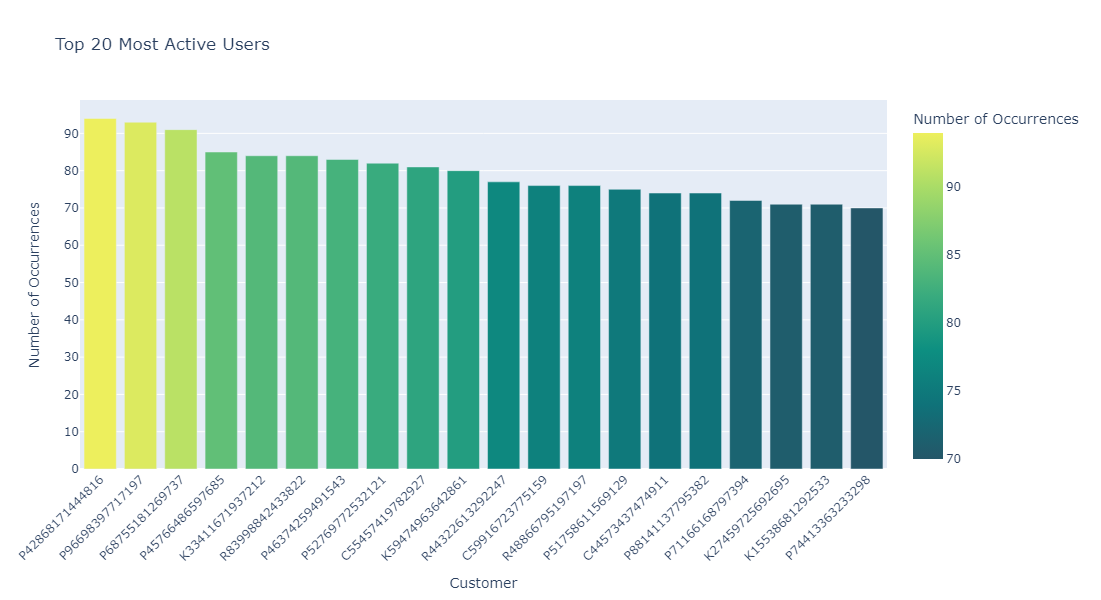

In [9]:
top_customers = df['customer'].value_counts().head(20)

# Create a DataFrame for plotting
data_for_plot = pd.DataFrame({'Customer': top_customers.index, 'Count': top_customers.values})

fig = px.bar(data_for_plot, x='Customer', y='Count', 
             title='Top 20 Most Active Users', 
             labels={'Customer':'Customer', 'Count':'Number of Occurrences'},
             color='Count', 
             color_continuous_scale='aggrnyl')

# Customize the layout
fig.update_layout(xaxis_tickangle=-45, 
                  xaxis_title='Customer', 
                  yaxis_title='Number of Occurrences',
                  height=600)
fig.show()

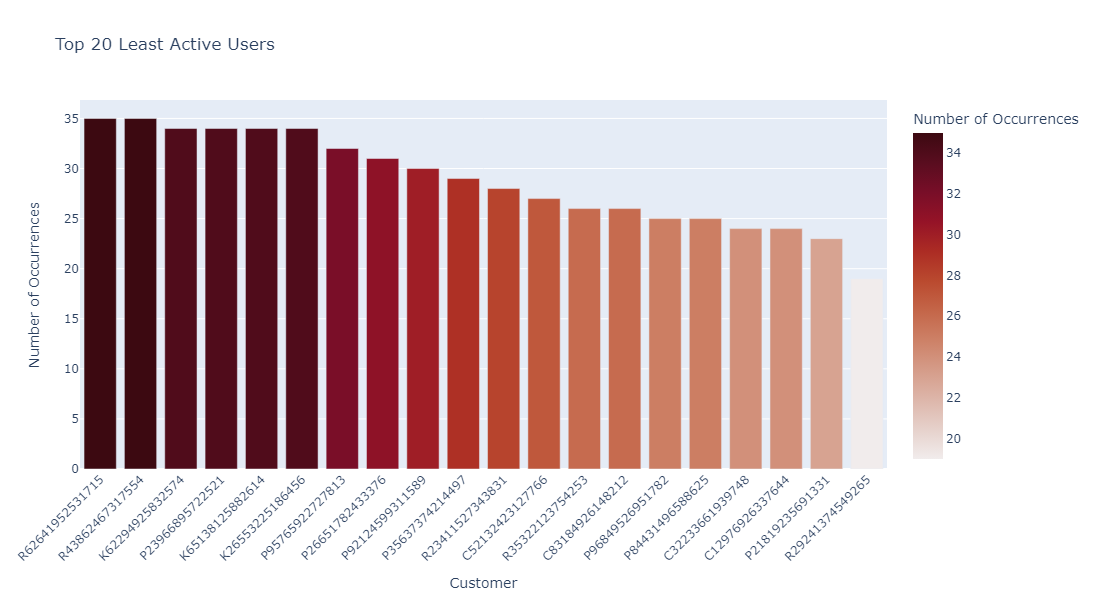

In [10]:
bottom_customers = df['customer'].value_counts().tail(20)

data_for_plot = pd.DataFrame({'Customer': bottom_customers.index, 'Count': bottom_customers.values})

fig = px.bar(data_for_plot, x='Customer', y='Count', 
             title='Top 20 Least Active Users', 
             labels={'Customer':'Customer', 'Count':'Number of Occurrences'},
             color='Count', 
             color_continuous_scale='amp')

fig.update_layout(xaxis_tickangle=-45, 
                  xaxis_title='Customer', 
                  yaxis_title='Number of Occurrences',
                  height=600) 
fig.show()

## Customer country

Let's get overall stats from this column and also check from which countries we have the mose of the clients.

In [11]:
df.customer_country.value_counts()

customer_country
UK    2112
US    1795
SG    1395
Name: count, dtype: int64

There are only 3 countries represented. Let's check out where are top customers that make transactions are from. The uysers from UK are prevailing but slighly in comparison with the US.

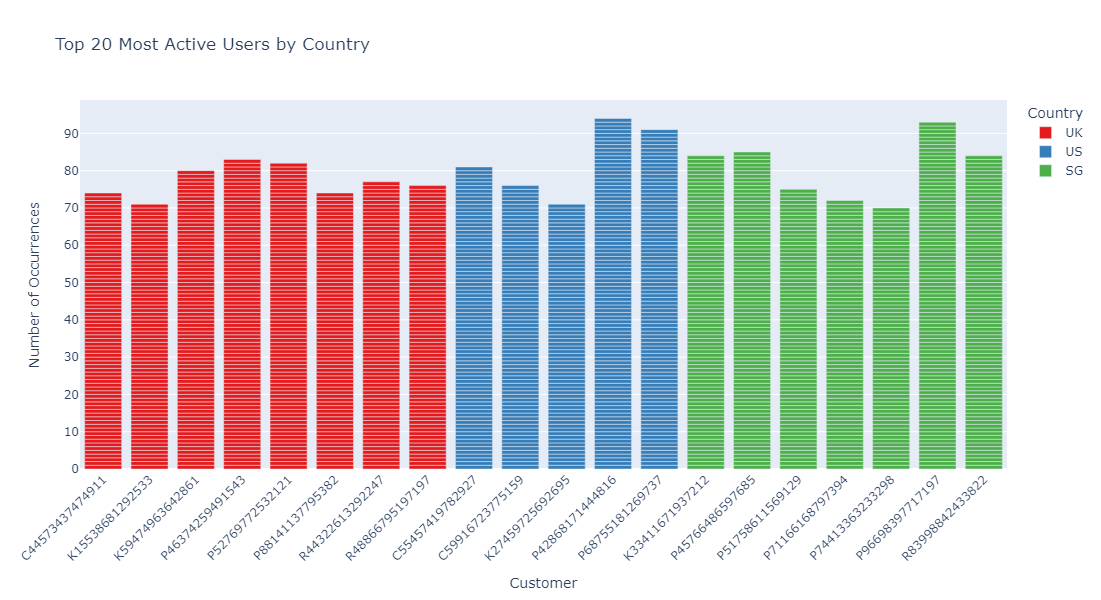

In [12]:
top_customers = df['customer'].value_counts().head(20).index
filtered_df = df[df['customer'].isin(top_customers)]

# Create the bar chart
fig = px.bar(filtered_df, x='customer', color='customer_country',
             title='Top 20 Most Active Users by Country',
             labels={'customer': 'Customer', 'count': 'Number of Occurrences', 'customer_country': 'Country'},
             color_discrete_sequence=px.colors.qualitative.Set1)

fig.update_layout(xaxis_tickangle=-45, 
                  xaxis_title='Customer',
                  yaxis_title='Number of Occurrences',
                  height=600) # Adjust height as needed
fig.show()

# Counterparty countre

Let's ivestigate which countries got most transactions.

In [13]:
df.counterparty_country.value_counts()

counterparty_country
CN               619
UK               614
JP               537
US               494
DE               484
FR               455
HK               453
BR               392
SG               375
IN               340
United States     23
USA               17
Name: count, dtype: int64

There are also unknown counties. Meaning that we have some missing values.

In [14]:
df.isnull().sum()

customer                  0
customer_country          0
fraud_flag                0
timestamp                 0
counterparty              0
counterparty_country    499
type                      0
ccy                       0
amount                    0
dtype: int64

In [15]:
print(f'Total {round(len(df[df.counterparty_country.isna()]) / len(df), 2) * 100}% entries are missing for the ccounterparty_country feature')

Total 9.0% entries are missing for the ccounterparty_country feature


Being honest, this is not a lot in comparison of the total entries. But before making dropping this column or doing anything else, let's tale a look at the `fraud_flag` for this feature.

In [16]:
df[df.counterparty_country.isna()]['fraud_flag'].value_counts()

fraud_flag
N    489
Y     10
Name: count, dtype: int64

About 2% of the missing values for the `counterparty_country` were connected to the fraud, which is not that much. For the simplicity let's replace missing values with `unknown`.

In [17]:
df['counterparty_country'].fillna('unknown', inplace=True)

In [18]:
df.isnull().sum()

customer                0
customer_country        0
fraud_flag              0
timestamp               0
counterparty            0
counterparty_country    0
type                    0
ccy                     0
amount                  0
dtype: int64

## Counterparty

In [19]:
print('Counterparty column itself is a ', type(df.counterparty.at[0]))

Counterparty column itself is a  <class 'numpy.float64'>


In [20]:
print(f'There are {df.counterparty.nunique()} unique entries')

There are 381 unique entries


In [21]:
df.counterparty.value_counts().head(10)

counterparty
8.259650e+13    34
7.672820e+13    33
4.862310e+13    33
8.369920e+13    30
6.649300e+13    29
1.673240e+13    29
7.558140e+13    29
7.161990e+13    29
3.793640e+13    29
2.736890e+13    29
Name: count, dtype: int64

**Note**: More information on the `counterparty` feature needed.

In [22]:
df[df.counterparty_country == 'USA']['counterparty'].value_counts()

counterparty
2.344810e+13    6
8.286580e+13    3
6.733150e+13    2
8.259650e+13    2
6.661170e+13    1
8.721260e+13    1
1.515450e+13    1
8.872810e+13    1
Name: count, dtype: int64

It is either identifier for different counterparties or a score for various counterparties. Let's try to prove the last guess.

In [23]:
df[df.fraud_flag == 'Y']['counterparty'].value_counts().head(), df[df.fraud_flag == 'N']['counterparty'].value_counts().head()

(counterparty
 4.862310e+13    13
 8.259650e+13    10
 6.928210e+13     6
 8.341960e+13     5
 3.339140e+13     4
 Name: count, dtype: int64,
 counterparty
 2.736890e+13    29
 7.558140e+13    29
 6.381250e+13    29
 7.672820e+13    29
 9.414620e+13    29
 Name: count, dtype: int64)

More information might be gathered throughout the correlation `heatmap`.

## Type

Let's see what types of transactions are.

In [24]:
df.type.value_counts()

type
TRANSFER      716
TT            705
DIVIDEND      691
INTEREST      665
OTHER         649
PAYMENT       633
INVESTMENT    627
BILLING       616
Name: count, dtype: int64

Let's see which payment types are having the most of fraud flags.

In [25]:
df[df.fraud_flag == 'Y']['type'].value_counts()

type
PAYMENT       37
INVESTMENT    18
OTHER         12
TT             9
TRANSFER       8
DIVIDEND       3
INTEREST       2
BILLING        2
Name: count, dtype: int64

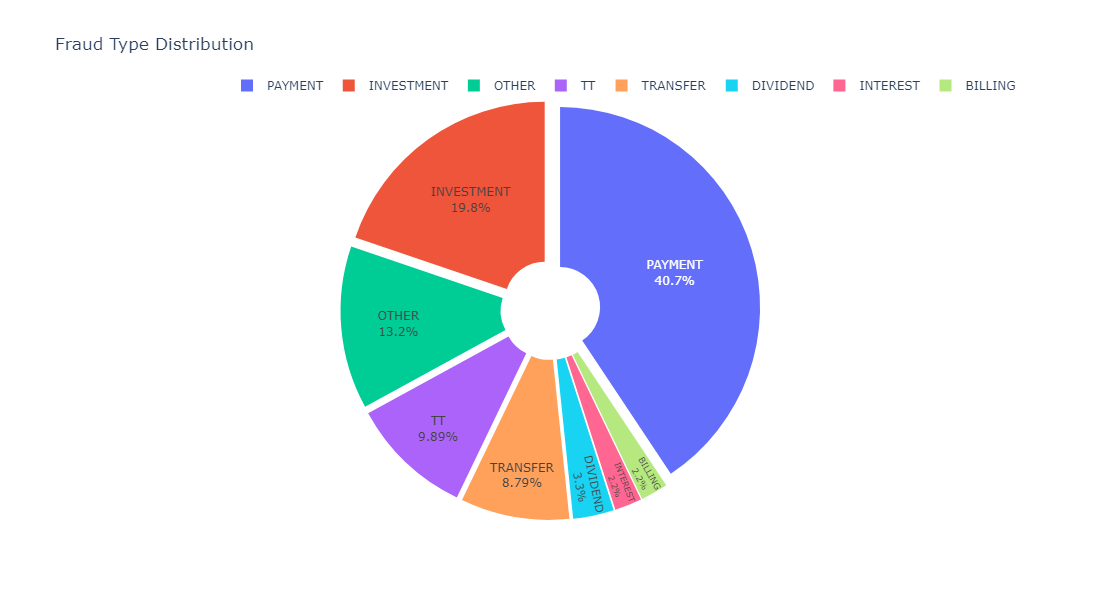

In [26]:
type_counts = df[df['fraud_flag'] == 'Y']['type'].value_counts()

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=type_counts.index, 
                             values=type_counts.values, 
                             pull=[0.05]*len(type_counts), 
                             hole=0.2)])  # Reduced hole size

# Customize the layout
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text='Fraud Type Distribution',
                  legend=dict(orientation='h', yanchor='bottom', y=1, xanchor='right', x=1),
                  width=800, height=600)  # Adjusted dimensions

fig.show()

## Fraud flag

Let's discover what causes the most of fraud flags. Whether they are corellated with the amount of transaction or specific country.

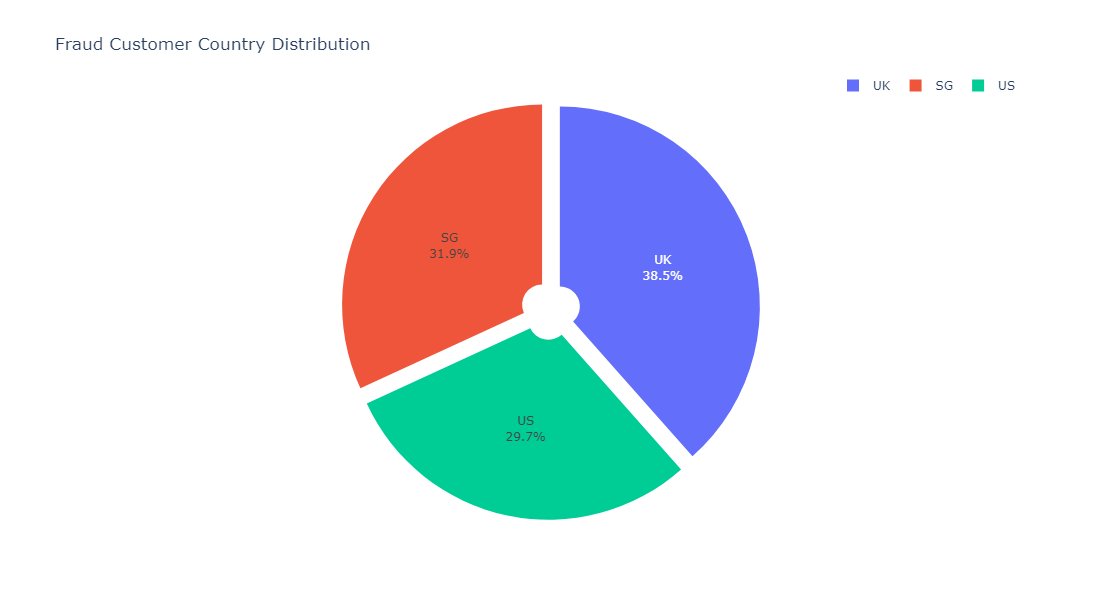

In [27]:
country_counts = df[df['fraud_flag'] == 'Y']['customer_country'].value_counts()

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=country_counts.index, 
                             values=country_counts.values, 
                             pull=[0.05]*len(country_counts), 
                             hole=0.1)])  # Reduced hole size

# Customize the layout
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text='Fraud Customer Country Distribution',
                  legend=dict(orientation='h', yanchor='bottom', y=1, xanchor='right', x=1),
                  width=800, height=600)  # Adjusted dimensions

fig.show()

We can safely say that there's not prevailing country for the fraud from the customer side.

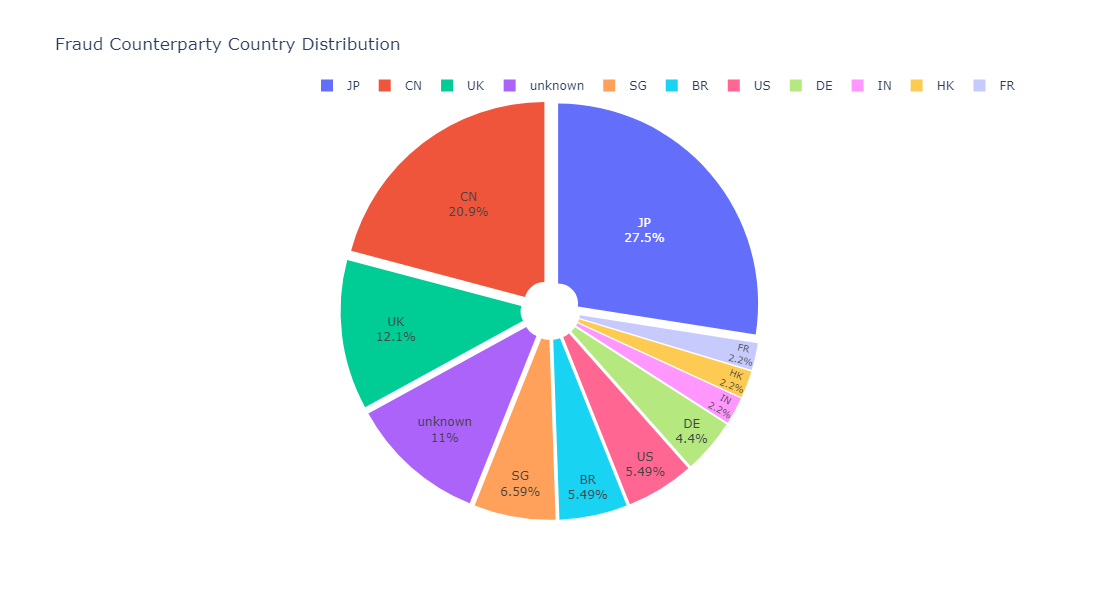

In [28]:
counterparty_counts = df[df['fraud_flag'] == 'Y']['counterparty_country'].value_counts()

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=counterparty_counts.index, 
                             values=counterparty_counts.values, 
                             pull=[0.05]*len(counterparty_counts), 
                             hole=0.1)])  # Reduced hole size

# Customize the layout
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text='Fraud Counterparty Country Distribution',
                  legend=dict(orientation='h', yanchor='bottom', y=1, xanchor='right', x=1),
                  width=800, height=600)  # Adjusted dimensions

fig.show()

We can observe that most of the transactions which were flagged as fraud were sent Japan.

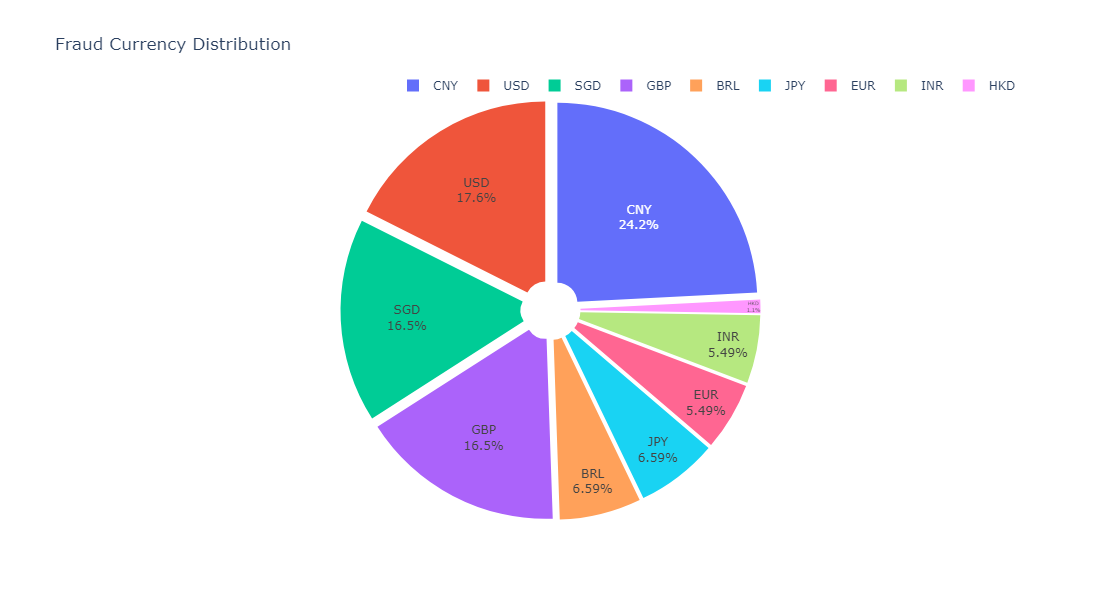

In [29]:
currency_counts = df[df['fraud_flag'] == 'Y']['ccy'].value_counts()

fig = go.Figure(data=[go.Pie(labels=currency_counts.index, 
                             values=currency_counts.values, 
                             pull=[0.05]*len(currency_counts), 
                             hole=0.1)])  # Reduced hole size

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text='Fraud Currency Distribution',
                  legend=dict(orientation='h', yanchor='bottom', y=1, xanchor='right', x=1),
                  width=800, height=600)  # Adjusted dimensions

fig.show()

Most of the fraud transactions were made in Chinese Yuan, the US Dollar on the second place and Singapore Dollar on the third one.

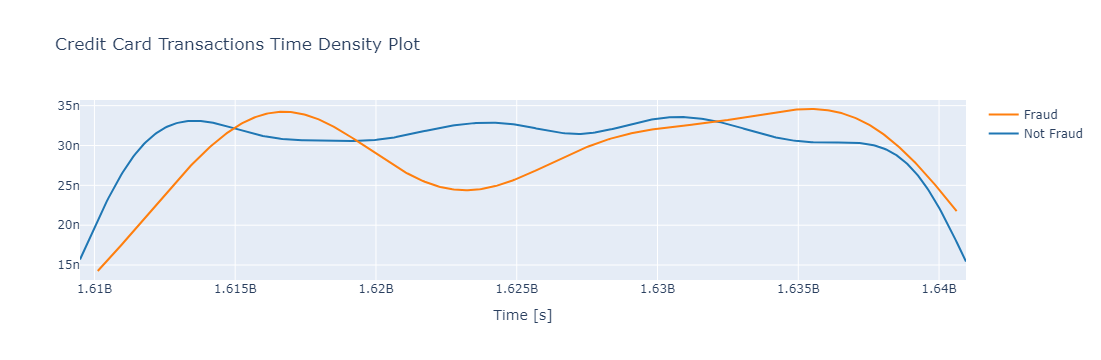

In [30]:
df['timestamp_seconds'] = (df['timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

class_0 = df.loc[df['fraud_flag'] == 'N']["timestamp_seconds"]
class_1 = df.loc[df['fraud_flag'] == 'Y']["timestamp_seconds"]



hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe (or any other assumed location) timezone.

In [31]:
df['amount'] = pd.to_numeric(df['amount'].str.replace('[^\d.]', '', regex=True), errors='coerce')

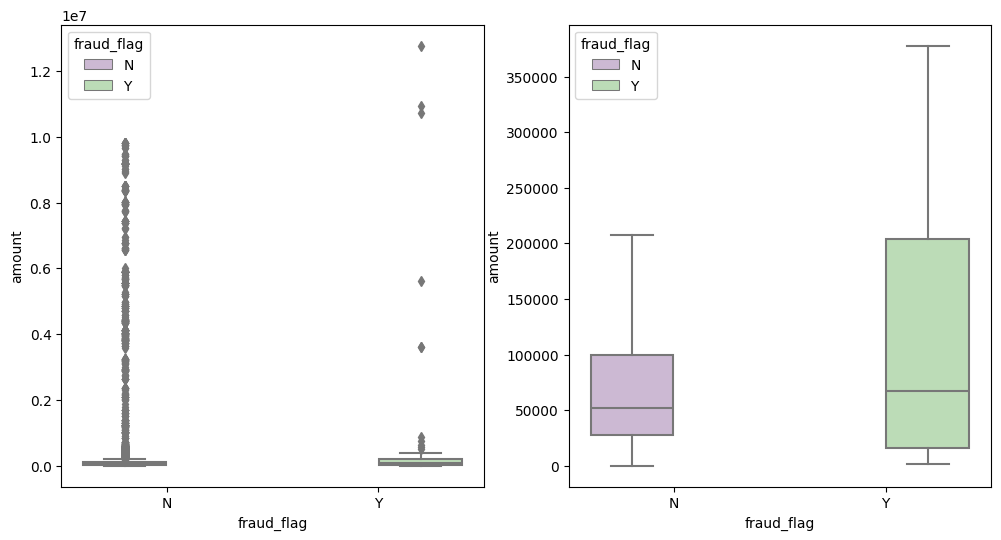

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="fraud_flag", y="amount", hue="fraud_flag",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="fraud_flag", y="amount", hue="fraud_flag",data=df, palette="PRGn",showfliers=False)

plt.show()

# Feature Engineering

Let's create some features which can possibly help us in the classification.

In [35]:
# Determining frequency of customer transactions
df['time_since_last_transaction'] = df.groupby('customer')['timestamp_seconds'].diff()

# Introduction of the average time between transaction per customer
df['avg_time_between_transactions'] = df.groupby('customer')['time_since_last_transaction'].mean()

In [36]:
# Number of transactions will be useful
df['transaction_count'] = df.groupby('customer')['timestamp_seconds'].cumcount() + 1

In [37]:
# Delta of the transaction is importans multiple transaction can signalise fradulent transactions
df['amount_delta'] = df.groupby('customer')['amount'].diff()

In [38]:
# Additional statistical features in regards to transactions
df['avg_transaction_amount'] = df.groupby('customer')['amount'].transform('mean')
df['median_transaction_amount'] = df.groupby('customer')['amount'].transform('median')
df['std_transaction_amount'] = df.groupby('customer')['amount'].transform('std')

In [39]:
# Introducing timestamp into classification algorithm
df['day_of_week'] = df['timestamp'].dt.dayofweek

In [40]:
df['Hour'] = df['timestamp_seconds'].apply(lambda x: np.floor(x / 3600))

In [41]:
df.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,timestamp_seconds,time_since_last_transaction,avg_time_between_transactions,transaction_count,amount_delta,avg_transaction_amount,median_transaction_amount,std_transaction_amount,day_of_week,Hour
0,C12976926337644,UK,N,2021-03-20 05:59:00,7.769740e+13,CN,OTHER,JPY,48625.25,1616219940,NaN,NaN,1,NaN,108256.376667,49192.97,124965.067165,5,448949.0
1,C12976926337644,UK,N,2021-05-02 03:00:00,7.769740e+13,CN,PAYMENT,GBP,20637.21,1619924400,3704460.0,NaN,2,-27988.04,108256.376667,49192.97,124965.067165,6,449979.0
2,C12976926337644,UK,N,2021-05-23 22:15:00,7.769740e+13,unknown,PAYMENT,USD,56691.27,1621808100,1883700.0,NaN,3,36054.06,108256.376667,49192.97,124965.067165,6,450502.0
3,C12976926337644,UK,N,2021-07-07 21:36:00,7.769740e+13,unknown,PAYMENT,CNY,343864.71,1625693760,3885660.0,NaN,4,287173.44,108256.376667,49192.97,124965.067165,2,451581.0
4,C12976926337644,UK,N,2021-09-02 00:14:00,7.769740e+13,unknown,PAYMENT,USD,57247.35,1630541640,4847880.0,NaN,5,-286617.36,108256.376667,49192.97,124965.067165,3,452928.0


Let's deal with the missing values.

In [42]:
df.isnull().sum()

customer                            0
customer_country                    0
fraud_flag                          0
timestamp                           0
counterparty                        0
counterparty_country                0
type                                0
ccy                                 0
amount                              0
timestamp_seconds                   0
time_since_last_transaction       100
avg_time_between_transactions    5302
transaction_count                   0
amount_delta                      100
avg_transaction_amount              0
median_transaction_amount           0
std_transaction_amount              0
day_of_week                         0
Hour                                0
dtype: int64

In [43]:
df.timestamp_seconds.fillna(0.0, inplace=True)
df.avg_time_between_transactions.fillna(0.0, inplace=True)
df.amount_delta.fillna(0.0, inplace=True)

In [44]:
df.time_since_last_transaction.fillna(0.0, inplace=True)

Now I need to create dummy features out of the categorical that we have. I could possibly convert them to embeddings especially if later today I choose to make a neural network.

In [45]:
df.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,timestamp_seconds,time_since_last_transaction,avg_time_between_transactions,transaction_count,amount_delta,avg_transaction_amount,median_transaction_amount,std_transaction_amount,day_of_week,Hour
0,C12976926337644,UK,N,2021-03-20 05:59:00,7.769740e+13,CN,OTHER,JPY,48625.25,1616219940,0.0,0.0,1,0.00,108256.376667,49192.97,124965.067165,5,448949.0
1,C12976926337644,UK,N,2021-05-02 03:00:00,7.769740e+13,CN,PAYMENT,GBP,20637.21,1619924400,3704460.0,0.0,2,-27988.04,108256.376667,49192.97,124965.067165,6,449979.0
2,C12976926337644,UK,N,2021-05-23 22:15:00,7.769740e+13,unknown,PAYMENT,USD,56691.27,1621808100,1883700.0,0.0,3,36054.06,108256.376667,49192.97,124965.067165,6,450502.0
3,C12976926337644,UK,N,2021-07-07 21:36:00,7.769740e+13,unknown,PAYMENT,CNY,343864.71,1625693760,3885660.0,0.0,4,287173.44,108256.376667,49192.97,124965.067165,2,451581.0
4,C12976926337644,UK,N,2021-09-02 00:14:00,7.769740e+13,unknown,PAYMENT,USD,57247.35,1630541640,4847880.0,0.0,5,-286617.36,108256.376667,49192.97,124965.067165,3,452928.0


In [46]:
def multiple_dummies(df: pd.DataFrame, col_list: list, prefixes: list, drop_first=True) -> pd.DataFrame:
    
    for col, prefix in zip(col_list, prefixes):
        
        df = pd.get_dummies(df, columns=[col], prefix=[prefix], drop_first=drop_first)
        
    return df

In [47]:
df = multiple_dummies(df, col_list = ['customer_country', 'fraud_flag', 'counterparty_country', 'type', 'ccy'], 
                      prefixes=['customer_country', 'y', 'counterparty_country', 'transac_type', 'currency'])

In [48]:
df.columns

Index(['customer', 'timestamp', 'counterparty', 'amount', 'timestamp_seconds',
       'time_since_last_transaction', 'avg_time_between_transactions',
       'transaction_count', 'amount_delta', 'avg_transaction_amount',
       'median_transaction_amount', 'std_transaction_amount', 'day_of_week',
       'Hour', 'customer_country_UK', 'customer_country_US', 'y_Y',
       'counterparty_country_CN', 'counterparty_country_DE',
       'counterparty_country_FR', 'counterparty_country_HK',
       'counterparty_country_IN', 'counterparty_country_JP',
       'counterparty_country_SG', 'counterparty_country_UK',
       'counterparty_country_US', 'counterparty_country_USA',
       'counterparty_country_United States', 'counterparty_country_unknown',
       'transac_type_DIVIDEND', 'transac_type_INTEREST',
       'transac_type_INVESTMENT', 'transac_type_OTHER', 'transac_type_PAYMENT',
       'transac_type_TRANSFER', 'transac_type_TT', 'currency_CNY',
       'currency_EUR', 'currency_GBP', 'currency

In [49]:
df.rename({'y_Y': 'y'}, axis=1, inplace=True)

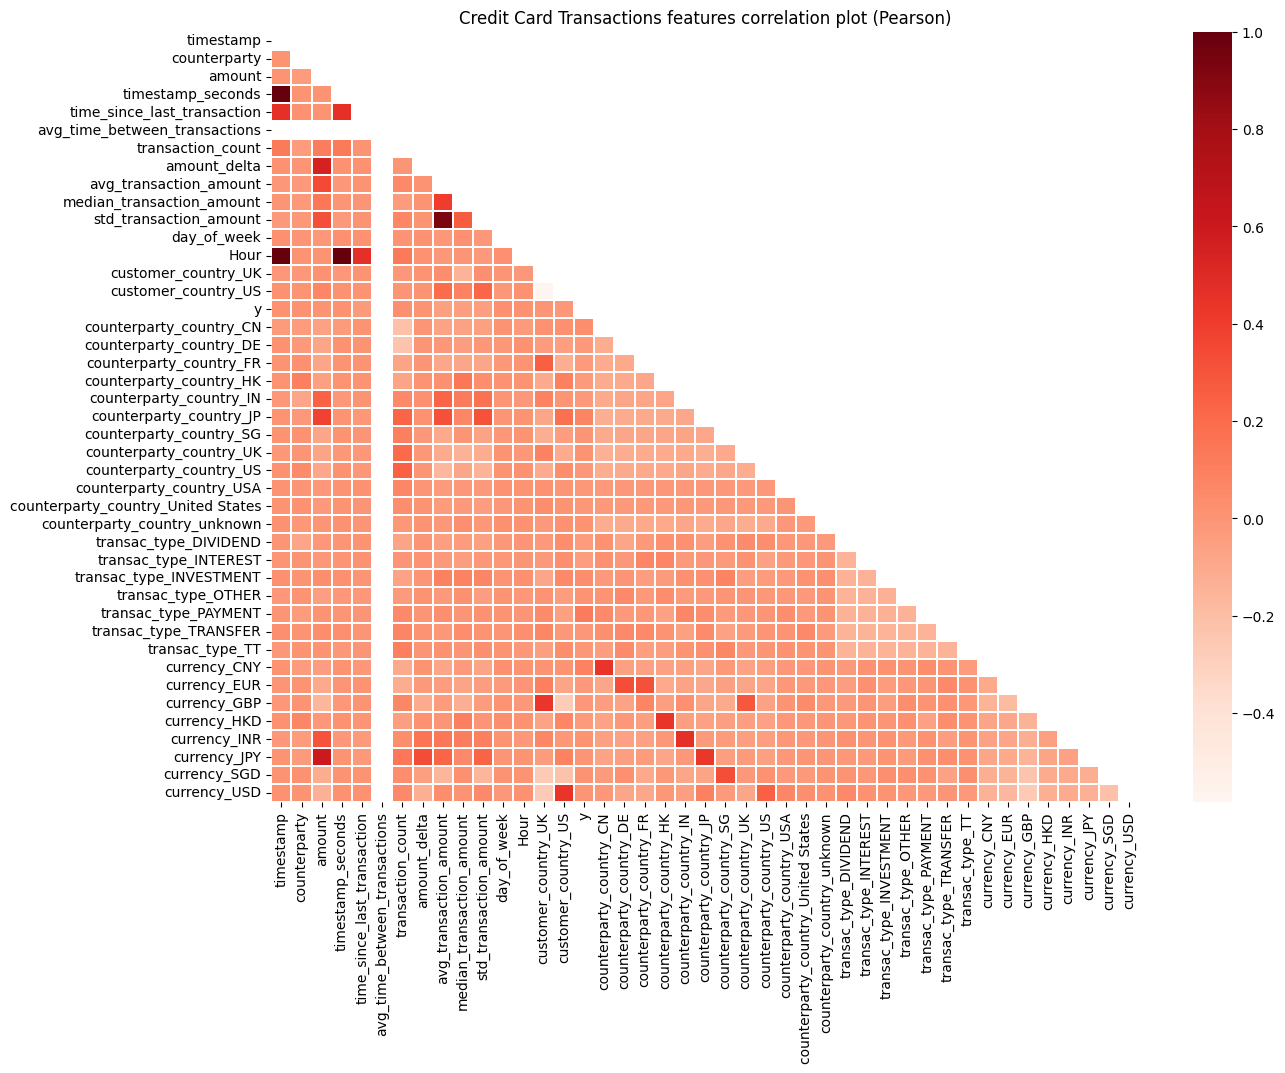

In [56]:
plt.figure(figsize = (14, 10))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = df.drop('customer', axis=1).corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.1, cmap="Reds")

plt.show()

According to the correlation plot we can drop 'avg_time_between_transactions'.

In [99]:
df.drop('avg_time_between_transactions', axis=1, inplace=True)

# Model training

For this task I will use several models. For the hyperparameter search the `Optuna` will be used. 


### Metric

The metric which I will try to maximize is ROC-AUC. ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) is a commonly used metric for binary classification problems.

Depending on the business requirements, precision and recall might be more critical. Precision focuses on minimizing false positives (fraudulent transactions misclassified as non-fraudulent), while recall emphasizes correctly identifying all fraudulent transactions. That is why it will be the other metric which I will check after model training.

## <span style='color: violet;'>Random Forest Classifier</span>

The Random Forest Classifier is an ensemble of decision trees, where each tree is trained on a random subset of the training data and makes a prediction. The final prediction is determined by a majority vote (classification) or averaging (regression) of the individual tree predictions. Randomization in the training process, such as using random subsets of features for each tree and random sampling of training data, helps to reduce overfitting and improve generalization performance. RandomForestClassifier in scikit-learn supports both classification and regression tasks.

In [105]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,  precision_recall_curve, average_precision_score, roc_curve, auc

In [101]:
df.y.value_counts()

y
False    5211
True       91
Name: count, dtype: int64

Since we have only 91 entry which is flagged as fraudulent this data is imbalanced. As the result I will use train-test split for imbalanced dataset, basically `stratify` parametere in `train_test_split`.

In [109]:
X = df.drop(['y', 'customer', 'timestamp'], axis=1)
y = df.y

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    shuffle=True)

In [138]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 3, 40)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Create and train the Random Forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    model.fit(X_train, y_train)

    # Get predicted probabilities for the validation set
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    return auc_roc

In [139]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2500)

[I 2024-01-09 20:40:59,820] A new study created in memory with name: no-name-1cefef72-6c33-4689-8766-25e56b72885f
[I 2024-01-09 20:40:59,883] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 53, 'max_depth': 14, 'min_samples_split': 0.4636041883037867, 'min_samples_leaf': 0.36237021320207974, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5.
[I 2024-01-09 20:41:00,546] Trial 1 finished with value: 0.7849419409822094 and parameters: {'n_estimators': 234, 'max_depth': 29, 'min_samples_split': 0.19537599115479998, 'min_samples_leaf': 0.29382544389258536, 'max_features': None}. Best is trial 1 with value: 0.7849419409822094.
[I 2024-01-09 20:41:00,761] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 204, 'max_depth': 16, 'min_samples_split': 0.10810198695171917, 'min_samples_leaf': 0.4715435047974528, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7849419409822094.
[I 2024-01-09 20:41:00,953] Trial 3 finished with value: 0.5 and parameters

[I 2024-01-09 20:41:12,480] Trial 29 finished with value: 0.8903270480451688 and parameters: {'n_estimators': 169, 'max_depth': 32, 'min_samples_split': 0.2417323133375347, 'min_samples_leaf': 0.1828122306777503, 'max_features': 'log2'}. Best is trial 20 with value: 0.8955470331309259.
[I 2024-01-09 20:41:12,807] Trial 30 finished with value: 0.8771172898689679 and parameters: {'n_estimators': 224, 'max_depth': 27, 'min_samples_split': 0.13555442985750238, 'min_samples_leaf': 0.201073669185756, 'max_features': 'log2'}. Best is trial 20 with value: 0.8955470331309259.
[I 2024-01-09 20:41:13,191] Trial 31 finished with value: 0.8953339725151805 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 0.2357982060812664, 'min_samples_leaf': 0.16979523260661705, 'max_features': 'log2'}. Best is trial 20 with value: 0.8955470331309259.
[I 2024-01-09 20:41:13,570] Trial 32 finished with value: 0.894321934590391 and parameters: {'n_estimators': 244, 'max_depth': 22, 'min_sa

[I 2024-01-09 20:41:20,949] Trial 58 finished with value: 0.895600298284862 and parameters: {'n_estimators': 86, 'max_depth': 34, 'min_samples_split': 0.1861220403527545, 'min_samples_leaf': 0.18074085022682868, 'max_features': 'sqrt'}. Best is trial 56 with value: 0.9080643443059551.
[I 2024-01-09 20:41:21,040] Trial 59 finished with value: 0.8867050175775008 and parameters: {'n_estimators': 54, 'max_depth': 32, 'min_samples_split': 0.20845918678878794, 'min_samples_leaf': 0.23769599250358867, 'max_features': 'log2'}. Best is trial 56 with value: 0.9080643443059551.
[I 2024-01-09 20:41:21,208] Trial 60 finished with value: 0.8976243741344413 and parameters: {'n_estimators': 107, 'max_depth': 35, 'min_samples_split': 0.26679204619171537, 'min_samples_leaf': 0.19059744335922763, 'max_features': 'log2'}. Best is trial 56 with value: 0.9080643443059551.
[I 2024-01-09 20:41:21,372] Trial 61 finished with value: 0.8945882603600724 and parameters: {'n_estimators': 107, 'max_depth': 35, 'min_

[I 2024-01-09 20:41:24,849] Trial 87 finished with value: 0.8541067433684884 and parameters: {'n_estimators': 50, 'max_depth': 39, 'min_samples_split': 0.4326825978851057, 'min_samples_leaf': 0.14784079545084494, 'max_features': None}. Best is trial 74 with value: 0.9164802386278896.
[I 2024-01-09 20:41:25,050] Trial 88 finished with value: 0.8873441994247363 and parameters: {'n_estimators': 118, 'max_depth': 37, 'min_samples_split': 0.31615537006711003, 'min_samples_leaf': 0.12913690232784333, 'max_features': 'log2'}. Best is trial 74 with value: 0.9164802386278896.
[I 2024-01-09 20:41:25,204] Trial 89 finished with value: 0.8843080856503676 and parameters: {'n_estimators': 88, 'max_depth': 38, 'min_samples_split': 0.38540227408225425, 'min_samples_leaf': 0.12330978986286031, 'max_features': 'log2'}. Best is trial 74 with value: 0.9164802386278896.
[I 2024-01-09 20:41:25,326] Trial 90 finished with value: 0.9055608820709492 and parameters: {'n_estimators': 72, 'max_depth': 40, 'min_sa

[I 2024-01-09 20:41:29,195] Trial 116 finished with value: 0.902471503142644 and parameters: {'n_estimators': 67, 'max_depth': 34, 'min_samples_split': 0.2708537898166557, 'min_samples_leaf': 0.17690936268897015, 'max_features': 'log2'}. Best is trial 111 with value: 0.9197294130180036.
[I 2024-01-09 20:41:29,299] Trial 117 finished with value: 0.9181314583999147 and parameters: {'n_estimators': 55, 'max_depth': 35, 'min_samples_split': 0.28798530429406066, 'min_samples_leaf': 0.14703969915731255, 'max_features': 'log2'}. Best is trial 111 with value: 0.9197294130180036.
[I 2024-01-09 20:41:29,438] Trial 118 finished with value: 0.9094492383082986 and parameters: {'n_estimators': 77, 'max_depth': 32, 'min_samples_split': 0.2897245939555951, 'min_samples_leaf': 0.1644523055172525, 'max_features': 'log2'}. Best is trial 111 with value: 0.9197294130180036.
[I 2024-01-09 20:41:29,533] Trial 119 finished with value: 0.9130712687759668 and parameters: {'n_estimators': 50, 'max_depth': 35, 'm

[I 2024-01-09 20:41:33,575] Trial 145 finished with value: 0.9046021093000959 and parameters: {'n_estimators': 68, 'max_depth': 29, 'min_samples_split': 0.25441509001315077, 'min_samples_leaf': 0.17005502277725917, 'max_features': 'log2'}. Best is trial 111 with value: 0.9197294130180036.
[I 2024-01-09 20:41:33,679] Trial 146 finished with value: 0.9152551400873549 and parameters: {'n_estimators': 50, 'max_depth': 32, 'min_samples_split': 0.2294588937490679, 'min_samples_leaf': 0.1463536694414369, 'max_features': 'log2'}. Best is trial 111 with value: 0.9197294130180036.
[I 2024-01-09 20:41:33,784] Trial 147 finished with value: 0.9194098220943858 and parameters: {'n_estimators': 57, 'max_depth': 32, 'min_samples_split': 0.20646428346812407, 'min_samples_leaf': 0.15378469005084622, 'max_features': 'log2'}. Best is trial 111 with value: 0.9197294130180036.
[I 2024-01-09 20:41:33,908] Trial 148 finished with value: 0.9040694577607329 and parameters: {'n_estimators': 62, 'max_depth': 31, 

[I 2024-01-09 20:41:37,112] Trial 174 finished with value: 0.7866464259081709 and parameters: {'n_estimators': 64, 'max_depth': 32, 'min_samples_split': 0.24391190641820196, 'min_samples_leaf': 0.28642336811497315, 'max_features': 'log2'}. Best is trial 152 with value: 0.9203153297113028.
[I 2024-01-09 20:41:37,236] Trial 175 finished with value: 0.9009800788324278 and parameters: {'n_estimators': 70, 'max_depth': 29, 'min_samples_split': 0.22402428701539437, 'min_samples_leaf': 0.1658815845499032, 'max_features': 'log2'}. Best is trial 152 with value: 0.9203153297113028.
[I 2024-01-09 20:41:37,340] Trial 176 finished with value: 0.9180249280920422 and parameters: {'n_estimators': 55, 'max_depth': 33, 'min_samples_split': 0.29826163666458383, 'min_samples_leaf': 0.14448683711116903, 'max_features': 'log2'}. Best is trial 152 with value: 0.9203153297113028.
[I 2024-01-09 20:41:37,441] Trial 177 finished with value: 0.9134973900074571 and parameters: {'n_estimators': 50, 'max_depth': 33,

[I 2024-01-09 20:41:42,671] Trial 203 finished with value: 0.9127516778523489 and parameters: {'n_estimators': 50, 'max_depth': 28, 'min_samples_split': 0.3079101372332781, 'min_samples_leaf': 0.15103813653215079, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:42,782] Trial 204 finished with value: 0.9183445190156599 and parameters: {'n_estimators': 59, 'max_depth': 27, 'min_samples_split': 0.26477860199891884, 'min_samples_leaf': 0.16183097290509155, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:42,909] Trial 205 finished with value: 0.9063065942260573 and parameters: {'n_estimators': 69, 'max_depth': 21, 'min_samples_split': 0.27907889423907734, 'min_samples_leaf': 0.1389237779828761, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:43,022] Trial 206 finished with value: 0.9115798444657504 and parameters: {'n_estimators': 62, 'max_depth': 29, 

[I 2024-01-09 20:41:47,109] Trial 232 finished with value: 0.901193139448173 and parameters: {'n_estimators': 50, 'max_depth': 34, 'min_samples_split': 0.27769474482034984, 'min_samples_leaf': 0.1964637175103682, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:47,215] Trial 233 finished with value: 0.8872376691168637 and parameters: {'n_estimators': 50, 'max_depth': 26, 'min_samples_split': 0.25165079076889, 'min_samples_leaf': 0.1088949523307105, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:47,334] Trial 234 finished with value: 0.9108873974645788 and parameters: {'n_estimators': 63, 'max_depth': 34, 'min_samples_split': 0.2348280515285928, 'min_samples_leaf': 0.15197098098118772, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:47,445] Trial 235 finished with value: 0.9157345264727815 and parameters: {'n_estimators': 59, 'max_depth': 28, 'min_

[I 2024-01-09 20:41:50,780] Trial 261 finished with value: 0.8437466709278789 and parameters: {'n_estimators': 60, 'max_depth': 35, 'min_samples_split': 0.4217225025075909, 'min_samples_leaf': 0.18290141115931746, 'max_features': None}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:50,908] Trial 262 finished with value: 0.9051347608394588 and parameters: {'n_estimators': 71, 'max_depth': 32, 'min_samples_split': 0.2762871558108274, 'min_samples_leaf': 0.15873141543454994, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:51,158] Trial 263 finished with value: 0.8891552146585704 and parameters: {'n_estimators': 141, 'max_depth': 34, 'min_samples_split': 0.17441280726722447, 'min_samples_leaf': 0.12740234194710623, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:51,266] Trial 264 finished with value: 0.9182912538617236 and parameters: {'n_estimators': 56, 'max_depth': 29, '

[I 2024-01-09 20:41:54,834] Trial 290 finished with value: 0.9093959731543624 and parameters: {'n_estimators': 50, 'max_depth': 29, 'min_samples_split': 0.3067745574327514, 'min_samples_leaf': 0.15027908845302865, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:54,942] Trial 291 finished with value: 0.9169596250133163 and parameters: {'n_estimators': 56, 'max_depth': 33, 'min_samples_split': 0.24623012022397284, 'min_samples_leaf': 0.15995478088523873, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:55,075] Trial 292 finished with value: 0.8975178438265686 and parameters: {'n_estimators': 71, 'max_depth': 29, 'min_samples_split': 0.3988843927212195, 'min_samples_leaf': 0.14124860426936514, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:55,198] Trial 293 finished with value: 0.9098753595397892 and parameters: {'n_estimators': 62, 'max_depth': 32, 

[I 2024-01-09 20:41:58,530] Trial 319 finished with value: 0.9154682007031 and parameters: {'n_estimators': 57, 'max_depth': 31, 'min_samples_split': 0.23184196329079457, 'min_samples_leaf': 0.17277010918223873, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:58,633] Trial 320 finished with value: 0.9187173750932139 and parameters: {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 0.2095342734323369, 'min_samples_leaf': 0.16283000070314965, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:59,149] Trial 321 finished with value: 0.8887290934270801 and parameters: {'n_estimators': 328, 'max_depth': 30, 'min_samples_split': 0.2020238570525083, 'min_samples_leaf': 0.16310596465929167, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:41:59,256] Trial 322 finished with value: 0.8952274422073079 and parameters: {'n_estimators': 50, 'max_depth': 30, 'm

[I 2024-01-09 20:42:02,830] Trial 348 finished with value: 0.9073718973047833 and parameters: {'n_estimators': 50, 'max_depth': 25, 'min_samples_split': 0.2384621414761349, 'min_samples_leaf': 0.1267975466181629, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:02,933] Trial 349 finished with value: 0.9133908596995846 and parameters: {'n_estimators': 50, 'max_depth': 32, 'min_samples_split': 0.2593900306230959, 'min_samples_leaf': 0.14230736628344848, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:03,524] Trial 350 finished with value: 0.8780227974858847 and parameters: {'n_estimators': 343, 'max_depth': 22, 'min_samples_split': 0.27795374565840586, 'min_samples_leaf': 0.10125898978156914, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:03,651] Trial 351 finished with value: 0.8606050921487163 and parameters: {'n_estimators': 76, 'max_depth': 30, 

[I 2024-01-09 20:42:08,261] Trial 377 finished with value: 0.8592201981463726 and parameters: {'n_estimators': 67, 'max_depth': 28, 'min_samples_split': 0.2466450451969301, 'min_samples_leaf': 0.2592300128568328, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:08,376] Trial 378 finished with value: 0.913124533929903 and parameters: {'n_estimators': 56, 'max_depth': 16, 'min_samples_split': 0.3364017598402167, 'min_samples_leaf': 0.14495177238949927, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:08,501] Trial 379 finished with value: 0.908596995845318 and parameters: {'n_estimators': 63, 'max_depth': 29, 'min_samples_split': 0.29967697498683943, 'min_samples_leaf': 0.16209830112844795, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:08,654] Trial 380 finished with value: 0.9077980185362735 and parameters: {'n_estimators': 80, 'max_depth': 24, 'mi

[I 2024-01-09 20:42:12,715] Trial 406 finished with value: 0.8862256311920742 and parameters: {'n_estimators': 66, 'max_depth': 25, 'min_samples_split': 0.5904352418032847, 'min_samples_leaf': 0.12352445122975741, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:12,803] Trial 407 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 4, 'min_samples_split': 0.6575129527859218, 'min_samples_leaf': 0.15447582456779854, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:12,925] Trial 408 finished with value: 0.8972515180568872 and parameters: {'n_estimators': 61, 'max_depth': 30, 'min_samples_split': 0.1290487914961721, 'min_samples_leaf': 0.1897522595544368, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:13,030] Trial 409 finished with value: 0.9177586023223606 and parameters: {'n_estimators': 50, 'max_depth': 31, 'min_samples_split

[I 2024-01-09 20:42:16,680] Trial 435 finished with value: 0.8642271226163845 and parameters: {'n_estimators': 62, 'max_depth': 28, 'min_samples_split': 0.5604592058430076, 'min_samples_leaf': 0.2566650303916889, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:16,771] Trial 436 finished with value: 0.5 and parameters: {'n_estimators': 55, 'max_depth': 33, 'min_samples_split': 0.14970708701696475, 'min_samples_leaf': 0.4942097587687875, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:16,903] Trial 437 finished with value: 0.9090231170768083 and parameters: {'n_estimators': 67, 'max_depth': 32, 'min_samples_split': 0.12454739314326561, 'min_samples_leaf': 0.15386643894023008, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:16,993] Trial 438 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 26, 'min_samples_split': 0.24813570

[I 2024-01-09 20:42:21,053] Trial 464 finished with value: 0.9162671780121444 and parameters: {'n_estimators': 50, 'max_depth': 29, 'min_samples_split': 0.18777973745309431, 'min_samples_leaf': 0.15266194348313172, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:21,182] Trial 465 finished with value: 0.8792478960264196 and parameters: {'n_estimators': 69, 'max_depth': 30, 'min_samples_split': 0.13481188812951966, 'min_samples_leaf': 0.2079837118552444, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:21,276] Trial 466 finished with value: 0.5 and parameters: {'n_estimators': 57, 'max_depth': 31, 'min_samples_split': 0.16728250247014212, 'min_samples_leaf': 0.48629139230302887, 'max_features': 'log2'}. Best is trial 185 with value: 0.9213806327900286.
[I 2024-01-09 20:42:21,446] Trial 467 finished with value: 0.5 and parameters: {'n_estimators': 132, 'max_depth': 27, 'min_samples_split': 0.76252

[I 2024-01-09 20:42:25,220] Trial 493 finished with value: 0.9123788217747949 and parameters: {'n_estimators': 50, 'max_depth': 34, 'min_samples_split': 0.2764599288977531, 'min_samples_leaf': 0.1415373163103323, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:25,336] Trial 494 finished with value: 0.8898476616597422 and parameters: {'n_estimators': 61, 'max_depth': 36, 'min_samples_split': 0.5481999953180555, 'min_samples_leaf': 0.15479203220275994, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:25,431] Trial 495 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 35, 'min_samples_split': 0.2398009890138327, 'min_samples_leaf': 0.400133017720202, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:25,582] Trial 496 finished with value: 0.8890486843506977 and parameters: {'n_estimators': 73, 'max_depth': 36, 'min_samples_split'

[I 2024-01-09 20:42:29,019] Trial 522 finished with value: 0.9069457760732929 and parameters: {'n_estimators': 68, 'max_depth': 27, 'min_samples_split': 0.2142950640573025, 'min_samples_leaf': 0.14462000892960145, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:29,294] Trial 523 finished with value: 0.8867050175775008 and parameters: {'n_estimators': 145, 'max_depth': 28, 'min_samples_split': 0.27283814184904676, 'min_samples_leaf': 0.10573844875211966, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:29,430] Trial 524 finished with value: 0.903909662298924 and parameters: {'n_estimators': 62, 'max_depth': 31, 'min_samples_split': 0.2317142844357134, 'min_samples_leaf': 0.15342852224307124, 'max_features': 'sqrt'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:29,513] Trial 525 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 30, 'min_samples_sp

[I 2024-01-09 20:42:34,082] Trial 551 finished with value: 0.8847342068818579 and parameters: {'n_estimators': 91, 'max_depth': 30, 'min_samples_split': 0.26835182257423174, 'min_samples_leaf': 0.2074576906630619, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:34,209] Trial 552 finished with value: 0.9031106849898796 and parameters: {'n_estimators': 65, 'max_depth': 29, 'min_samples_split': 0.40972773587713207, 'min_samples_leaf': 0.15423352040331123, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:34,825] Trial 553 finished with value: 0.8692873122403323 and parameters: {'n_estimators': 351, 'max_depth': 35, 'min_samples_split': 0.3238641818015411, 'min_samples_leaf': 0.10091062472081619, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:34,924] Trial 554 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 28, 'min_samples_s

[I 2024-01-09 20:42:38,258] Trial 580 finished with value: 0.9029508895280707 and parameters: {'n_estimators': 108, 'max_depth': 28, 'min_samples_split': 0.30230168871144975, 'min_samples_leaf': 0.1472091045901035, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:38,362] Trial 581 finished with value: 0.8946415255140088 and parameters: {'n_estimators': 50, 'max_depth': 27, 'min_samples_split': 0.5730417169515718, 'min_samples_leaf': 0.15284532288572766, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:38,488] Trial 582 finished with value: 0.9129114733141579 and parameters: {'n_estimators': 61, 'max_depth': 29, 'min_samples_split': 0.15596761461857334, 'min_samples_leaf': 0.16269276356019047, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:38,627] Trial 583 finished with value: 0.9043890486843507 and parameters: {'n_estimators': 68, 'max_depth': 35,

[I 2024-01-09 20:42:41,747] Trial 609 finished with value: 0.9045488441461597 and parameters: {'n_estimators': 73, 'max_depth': 27, 'min_samples_split': 0.1461746370068057, 'min_samples_leaf': 0.12611188091777062, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:42,074] Trial 610 finished with value: 0.8868115478853734 and parameters: {'n_estimators': 185, 'max_depth': 28, 'min_samples_split': 0.1489496616212027, 'min_samples_leaf': 0.1290418956611452, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:42,212] Trial 611 finished with value: 0.9112602535421327 and parameters: {'n_estimators': 64, 'max_depth': 26, 'min_samples_split': 0.11701951229210802, 'min_samples_leaf': 0.13627110092421332, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:42,313] Trial 612 finished with value: 0.5 and parameters: {'n_estimators': 60, 'max_depth': 28, 'min_samples_sp

[I 2024-01-09 20:42:46,373] Trial 638 finished with value: 0.8886758282731437 and parameters: {'n_estimators': 56, 'max_depth': 28, 'min_samples_split': 0.5116934330568501, 'min_samples_leaf': 0.2156515243456375, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:46,507] Trial 639 finished with value: 0.877703206562267 and parameters: {'n_estimators': 75, 'max_depth': 28, 'min_samples_split': 0.11457857827086662, 'min_samples_leaf': 0.2390395707334299, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:46,607] Trial 640 finished with value: 0.5 and parameters: {'n_estimators': 61, 'max_depth': 27, 'min_samples_split': 0.35538680303742975, 'min_samples_leaf': 0.33226548953955054, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:46,695] Trial 641 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 25, 'min_samples_split': 0.701442986

[I 2024-01-09 20:42:50,983] Trial 667 finished with value: 0.9075316927665921 and parameters: {'n_estimators': 72, 'max_depth': 26, 'min_samples_split': 0.28613107914642566, 'min_samples_leaf': 0.13187198113235687, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:51,092] Trial 668 finished with value: 0.8946947906679451 and parameters: {'n_estimators': 56, 'max_depth': 33, 'min_samples_split': 0.6271586230129067, 'min_samples_leaf': 0.11912580827946609, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:51,212] Trial 669 finished with value: 0.8916054117396399 and parameters: {'n_estimators': 63, 'max_depth': 28, 'min_samples_split': 0.49980044989120526, 'min_samples_leaf': 0.14690048897505278, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:51,302] Trial 670 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 29, 'min_samples_s

[I 2024-01-09 20:42:54,647] Trial 696 finished with value: 0.5 and parameters: {'n_estimators': 62, 'max_depth': 29, 'min_samples_split': 0.8136080740325513, 'min_samples_leaf': 0.16053045895113227, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:54,735] Trial 697 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 36, 'min_samples_split': 0.6058809286414693, 'min_samples_leaf': 0.4774069992768582, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:54,888] Trial 698 finished with value: 0.9077447533823373 and parameters: {'n_estimators': 76, 'max_depth': 28, 'min_samples_split': 0.2440382522623692, 'min_samples_leaf': 0.14268853931573602, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:55,407] Trial 699 finished with value: 0.8942686694364547 and parameters: {'n_estimators': 335, 'max_depth': 26, 'min_samples_split': 0.15858724

[I 2024-01-09 20:42:59,190] Trial 726 finished with value: 0.8020400553957602 and parameters: {'n_estimators': 56, 'max_depth': 27, 'min_samples_split': 0.46777504946400306, 'min_samples_leaf': 0.28760789645648993, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:59,321] Trial 727 finished with value: 0.5 and parameters: {'n_estimators': 93, 'max_depth': 29, 'min_samples_split': 0.34035086669935377, 'min_samples_leaf': 0.43344008101158255, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:59,600] Trial 728 finished with value: 0.8921380632790028 and parameters: {'n_estimators': 153, 'max_depth': 36, 'min_samples_split': 0.18245323104961808, 'min_samples_leaf': 0.13283041313745417, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:42:59,718] Trial 729 finished with value: 0.5 and parameters: {'n_estimators': 75, 'max_depth': 28, 'min_samples_split': 0.3034

[I 2024-01-09 20:43:03,789] Trial 755 finished with value: 0.9148290188558643 and parameters: {'n_estimators': 62, 'max_depth': 28, 'min_samples_split': 0.2944757939874891, 'min_samples_leaf': 0.1329472187325684, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:03,883] Trial 756 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 0.7177369539194742, 'min_samples_leaf': 0.17689068896483687, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:04,002] Trial 757 finished with value: 0.5 and parameters: {'n_estimators': 72, 'max_depth': 33, 'min_samples_split': 0.8794235233642853, 'min_samples_leaf': 0.11688693979996198, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:04,133] Trial 758 finished with value: 0.9189304357089592 and parameters: {'n_estimators': 56, 'max_depth': 29, 'min_samples_split': 0.248754368

[I 2024-01-09 20:43:07,858] Trial 784 finished with value: 0.8881431767337808 and parameters: {'n_estimators': 50, 'max_depth': 28, 'min_samples_split': 0.3041257195143446, 'min_samples_leaf': 0.10258453309881736, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:07,990] Trial 785 finished with value: 0.902631298604453 and parameters: {'n_estimators': 62, 'max_depth': 30, 'min_samples_split': 0.33535752884427505, 'min_samples_leaf': 0.1889280582865785, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:08,197] Trial 786 finished with value: 0.8771172898689679 and parameters: {'n_estimators': 124, 'max_depth': 29, 'min_samples_split': 0.5964991124380312, 'min_samples_leaf': 0.226500593787343, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:08,399] Trial 787 finished with value: 0.8895280707361244 and parameters: {'n_estimators': 114, 'max_depth': 26, 'm

[I 2024-01-09 20:43:12,225] Trial 813 finished with value: 0.9061467987642484 and parameters: {'n_estimators': 64, 'max_depth': 28, 'min_samples_split': 0.21607634959073332, 'min_samples_leaf': 0.13811648163268364, 'max_features': 'sqrt'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:12,325] Trial 814 finished with value: 0.5 and parameters: {'n_estimators': 55, 'max_depth': 32, 'min_samples_split': 0.3434249879773381, 'min_samples_leaf': 0.3923973034221497, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:12,444] Trial 815 finished with value: 0.5 and parameters: {'n_estimators': 71, 'max_depth': 30, 'min_samples_split': 0.6272752437828417, 'min_samples_leaf': 0.3850539346088106, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:12,552] Trial 816 finished with value: 0.7687227016086076 and parameters: {'n_estimators': 50, 'max_depth': 28, 'min_samples_split': 0.279017542

[I 2024-01-09 20:43:15,956] Trial 842 finished with value: 0.8755193352508789 and parameters: {'n_estimators': 66, 'max_depth': 30, 'min_samples_split': 0.329939868513294, 'min_samples_leaf': 0.22327011913163353, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:16,082] Trial 843 finished with value: 0.9173857462448065 and parameters: {'n_estimators': 56, 'max_depth': 36, 'min_samples_split': 0.13383876164046907, 'min_samples_leaf': 0.166120111320057, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:16,608] Trial 844 finished with value: 0.8597794822627037 and parameters: {'n_estimators': 85, 'max_depth': 27, 'min_samples_split': 0.16143855283163613, 'min_samples_leaf': 0.14503287813935678, 'max_features': None}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:16,759] Trial 845 finished with value: 0.9061467987642484 and parameters: {'n_estimators': 76, 'max_depth': 29, 'min

[I 2024-01-09 20:43:20,232] Trial 871 finished with value: 0.8350644508362629 and parameters: {'n_estimators': 56, 'max_depth': 26, 'min_samples_split': 0.25938925946195523, 'min_samples_leaf': 0.2734400744936927, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:20,357] Trial 872 finished with value: 0.9142431021625652 and parameters: {'n_estimators': 50, 'max_depth': 29, 'min_samples_split': 0.21480701695005378, 'min_samples_leaf': 0.13839905979904502, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:20,505] Trial 873 finished with value: 0.9058272078406306 and parameters: {'n_estimators': 67, 'max_depth': 33, 'min_samples_split': 0.1909333565686682, 'min_samples_leaf': 0.16708817214984922, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:20,638] Trial 874 finished with value: 0.9161073825503355 and parameters: {'n_estimators': 61, 'max_depth': 28, 

[I 2024-01-09 20:43:24,923] Trial 900 finished with value: 0.8960264195163523 and parameters: {'n_estimators': 78, 'max_depth': 32, 'min_samples_split': 0.47063767219900227, 'min_samples_leaf': 0.15961113973877264, 'max_features': 'sqrt'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:25,023] Trial 901 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 34, 'min_samples_split': 0.9416799727454178, 'min_samples_leaf': 0.1345628677931824, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:25,135] Trial 902 finished with value: 0.5 and parameters: {'n_estimators': 68, 'max_depth': 28, 'min_samples_split': 0.6395252668598173, 'min_samples_leaf': 0.3293452214393194, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:25,262] Trial 903 finished with value: 0.920528390327048 and parameters: {'n_estimators': 56, 'max_depth': 5, 'min_samples_split': 0.22035153566

[I 2024-01-09 20:43:29,145] Trial 929 finished with value: 0.7681101523383402 and parameters: {'n_estimators': 63, 'max_depth': 6, 'min_samples_split': 0.5931916929845749, 'min_samples_leaf': 0.312381877921941, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:29,509] Trial 930 finished with value: 0.8543464365612017 and parameters: {'n_estimators': 56, 'max_depth': 36, 'min_samples_split': 0.2574767069205688, 'min_samples_leaf': 0.14842372492574382, 'max_features': None}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:29,624] Trial 931 finished with value: 0.9186641099392777 and parameters: {'n_estimators': 50, 'max_depth': 33, 'min_samples_split': 0.27763298051388663, 'min_samples_leaf': 0.1632316467246245, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:29,758] Trial 932 finished with value: 0.8213220411206988 and parameters: {'n_estimators': 69, 'max_depth': 13, 'min_s

[I 2024-01-09 20:43:33,867] Trial 958 finished with value: 0.5 and parameters: {'n_estimators': 57, 'max_depth': 28, 'min_samples_split': 0.37741177651558694, 'min_samples_leaf': 0.35745529811643006, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:33,984] Trial 959 finished with value: 0.9120592308511771 and parameters: {'n_estimators': 50, 'max_depth': 33, 'min_samples_split': 0.4288788324075804, 'min_samples_leaf': 0.14501079628845553, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:34,101] Trial 960 finished with value: 0.5 and parameters: {'n_estimators': 74, 'max_depth': 30, 'min_samples_split': 0.25735685790012186, 'min_samples_leaf': 0.42395398079025876, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:34,353] Trial 961 finished with value: 0.8643869180781932 and parameters: {'n_estimators': 160, 'max_depth': 35, 'min_samples_split': 0.27050

[I 2024-01-09 20:43:38,379] Trial 987 finished with value: 0.9111537232342601 and parameters: {'n_estimators': 58, 'max_depth': 23, 'min_samples_split': 0.6311235965193419, 'min_samples_leaf': 0.14483618634730985, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:38,487] Trial 988 finished with value: 0.5 and parameters: {'n_estimators': 62, 'max_depth': 29, 'min_samples_split': 0.9015824012599178, 'min_samples_leaf': 0.17694712905249158, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:38,650] Trial 989 finished with value: 0.9009268136784915 and parameters: {'n_estimators': 69, 'max_depth': 29, 'min_samples_split': 0.17459613487602196, 'min_samples_leaf': 0.13092572181036707, 'max_features': 'sqrt'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:38,777] Trial 990 finished with value: 0.9178651326302333 and parameters: {'n_estimators': 56, 'max_depth': 27, 'min_samples_sp

[I 2024-01-09 20:43:42,519] Trial 1016 finished with value: 0.5 and parameters: {'n_estimators': 86, 'max_depth': 25, 'min_samples_split': 0.7485364985531664, 'min_samples_leaf': 0.3511501671926939, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:42,648] Trial 1017 finished with value: 0.9103014807712795 and parameters: {'n_estimators': 56, 'max_depth': 28, 'min_samples_split': 0.10126135801104925, 'min_samples_leaf': 0.18025907714076658, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:42,858] Trial 1018 finished with value: 0.826941514860978 and parameters: {'n_estimators': 50, 'max_depth': 27, 'min_samples_split': 0.5597897400965058, 'min_samples_leaf': 0.14739183047952786, 'max_features': None}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:42,986] Trial 1019 finished with value: 0.8913923511238947 and parameters: {'n_estimators': 61, 'max_depth': 35, 'min_samples_sp

[I 2024-01-09 20:43:46,626] Trial 1045 finished with value: 0.5 and parameters: {'n_estimators': 66, 'max_depth': 27, 'min_samples_split': 0.8841514675781851, 'min_samples_leaf': 0.18247182862045638, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:46,732] Trial 1046 finished with value: 0.5 and parameters: {'n_estimators': 57, 'max_depth': 34, 'min_samples_split': 0.6887306040579015, 'min_samples_leaf': 0.1621689111736608, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:46,853] Trial 1047 finished with value: 0.5 and parameters: {'n_estimators': 73, 'max_depth': 33, 'min_samples_split': 0.21710058247919023, 'min_samples_leaf': 0.3803969052961826, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:46,965] Trial 1048 finished with value: 0.876265047405987 and parameters: {'n_estimators': 50, 'max_depth': 29, 'min_samples_split': 0.5841517230936105, 'mi

[I 2024-01-09 20:43:51,060] Trial 1074 finished with value: 0.9094492383082987 and parameters: {'n_estimators': 57, 'max_depth': 26, 'min_samples_split': 0.4048903652665873, 'min_samples_leaf': 0.14375936212973367, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:51,311] Trial 1075 finished with value: 0.8842548204964312 and parameters: {'n_estimators': 126, 'max_depth': 31, 'min_samples_split': 0.16593652931632905, 'min_samples_leaf': 0.11809206009068879, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:51,412] Trial 1076 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 0.7333067362888305, 'min_samples_leaf': 0.18149785160540421, 'max_features': 'sqrt'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:51,565] Trial 1077 finished with value: 0.904069457760733 and parameters: {'n_estimators': 68, 'max_depth': 29, 'min_sample

[I 2024-01-09 20:43:56,339] Trial 1103 finished with value: 0.8751997443272612 and parameters: {'n_estimators': 260, 'max_depth': 30, 'min_samples_split': 0.14395717525373738, 'min_samples_leaf': 0.21240377853550788, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:56,453] Trial 1104 finished with value: 0.5 and parameters: {'n_estimators': 66, 'max_depth': 26, 'min_samples_split': 0.8623639987791376, 'min_samples_leaf': 0.13803341246705125, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:56,851] Trial 1105 finished with value: 0.8492862469372535 and parameters: {'n_estimators': 61, 'max_depth': 27, 'min_samples_split': 0.36491270607972925, 'min_samples_leaf': 0.12438179592245954, 'max_features': None}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:43:56,972] Trial 1106 finished with value: 0.9111537232342601 and parameters: {'n_estimators': 56, 'max_depth': 35, 'min_sample

[I 2024-01-09 20:44:00,636] Trial 1132 finished with value: 0.5 and parameters: {'n_estimators': 222, 'max_depth': 29, 'min_samples_split': 0.24604508021521418, 'min_samples_leaf': 0.34130964938152525, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:00,743] Trial 1133 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 28, 'min_samples_split': 0.8059933125077898, 'min_samples_leaf': 0.4431964417630549, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:01,275] Trial 1134 finished with value: 0.8852668584212208 and parameters: {'n_estimators': 331, 'max_depth': 27, 'min_samples_split': 0.32553283833973506, 'min_samples_leaf': 0.15398247683102187, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:01,423] Trial 1135 finished with value: 0.7954884414615959 and parameters: {'n_estimators': 77, 'max_depth': 30, 'min_samples_split': 0.1

[I 2024-01-09 20:44:04,742] Trial 1161 finished with value: 0.8859593054223927 and parameters: {'n_estimators': 56, 'max_depth': 28, 'min_samples_split': 0.30814506782949846, 'min_samples_leaf': 0.2229345431452449, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:04,877] Trial 1162 finished with value: 0.8486736976669862 and parameters: {'n_estimators': 67, 'max_depth': 27, 'min_samples_split': 0.1620593326197916, 'min_samples_leaf': 0.26344765656005087, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:05,013] Trial 1163 finished with value: 0.8861723660381378 and parameters: {'n_estimators': 63, 'max_depth': 30, 'min_samples_split': 0.37079919011096996, 'min_samples_leaf': 0.20969739209098204, 'max_features': 'sqrt'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:05,143] Trial 1164 finished with value: 0.9173324810908703 and parameters: {'n_estimators': 56, 'max_depth': 

[I 2024-01-09 20:44:08,753] Trial 1190 finished with value: 0.801480771279429 and parameters: {'n_estimators': 56, 'max_depth': 7, 'min_samples_split': 0.4054154217247728, 'min_samples_leaf': 0.28899566937777377, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:08,874] Trial 1191 finished with value: 0.5 and parameters: {'n_estimators': 67, 'max_depth': 29, 'min_samples_split': 0.7671053924092832, 'min_samples_leaf': 0.21419994114716445, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:09,011] Trial 1192 finished with value: 0.9116331096196868 and parameters: {'n_estimators': 61, 'max_depth': 28, 'min_samples_split': 0.27016484131329416, 'min_samples_leaf': 0.1721811679356393, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:09,326] Trial 1193 finished with value: 0.8526153190582721 and parameters: {'n_estimators': 50, 'max_depth': 27, 'min_samples_s

[I 2024-01-09 20:44:13,057] Trial 1219 finished with value: 0.917811867476297 and parameters: {'n_estimators': 56, 'max_depth': 29, 'min_samples_split': 0.19471828716096928, 'min_samples_leaf': 0.1452656447243975, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:13,201] Trial 1220 finished with value: 0.8730158730158729 and parameters: {'n_estimators': 66, 'max_depth': 32, 'min_samples_split': 0.1643259861006576, 'min_samples_leaf': 0.22689958935080445, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:13,356] Trial 1221 finished with value: 0.873015873015873 and parameters: {'n_estimators': 82, 'max_depth': 35, 'min_samples_split': 0.31718225860589455, 'min_samples_leaf': 0.23827178480355254, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:13,488] Trial 1222 finished with value: 0.8851070629594119 and parameters: {'n_estimators': 61, 'max_depth': 27

[I 2024-01-09 20:44:17,723] Trial 1248 finished with value: 0.8895813358900607 and parameters: {'n_estimators': 61, 'max_depth': 29, 'min_samples_split': 0.14608920774699333, 'min_samples_leaf': 0.2016572984283843, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:17,854] Trial 1249 finished with value: 0.9105145413870246 and parameters: {'n_estimators': 50, 'max_depth': 32, 'min_samples_split': 0.23606186961609318, 'min_samples_leaf': 0.1303815092887898, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:17,967] Trial 1250 finished with value: 0.5 and parameters: {'n_estimators': 62, 'max_depth': 30, 'min_samples_split': 0.2020419247356837, 'min_samples_leaf': 0.47932131744684325, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:18,109] Trial 1251 finished with value: 0.8700330243954405 and parameters: {'n_estimators': 68, 'max_depth': 27, 'min_samples

[I 2024-01-09 20:44:22,041] Trial 1277 finished with value: 0.8839884947267498 and parameters: {'n_estimators': 60, 'max_depth': 32, 'min_samples_split': 0.20246673173683233, 'min_samples_leaf': 0.22500048593021918, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:22,179] Trial 1278 finished with value: 0.9200490039416214 and parameters: {'n_estimators': 56, 'max_depth': 24, 'min_samples_split': 0.2755853155327625, 'min_samples_leaf': 0.1522269083297601, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:22,285] Trial 1279 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.310267102220274, 'min_samples_leaf': 0.3729165284874454, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:22,422] Trial 1280 finished with value: 0.9170128901672525 and parameters: {'n_estimators': 56, 'max_depth': 23, 'min_samples_s

[I 2024-01-09 20:44:26,916] Trial 1306 finished with value: 0.8967188665175242 and parameters: {'n_estimators': 61, 'max_depth': 26, 'min_samples_split': 0.19372638837839484, 'min_samples_leaf': 0.19644691301595343, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:27,029] Trial 1307 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 26, 'min_samples_split': 0.14940614666639765, 'min_samples_leaf': 0.3888556859427823, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:27,154] Trial 1308 finished with value: 0.817726643229999 and parameters: {'n_estimators': 50, 'max_depth': 26, 'min_samples_split': 0.1795308566143305, 'min_samples_leaf': 0.28098825857050974, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:27,273] Trial 1309 finished with value: 0.5 and parameters: {'n_estimators': 62, 'max_depth': 25, 'min_samples_split': 0.6654

[I 2024-01-09 20:44:31,256] Trial 1335 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 23, 'min_samples_split': 0.48315694444770724, 'min_samples_leaf': 0.469821009683081, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:31,415] Trial 1336 finished with value: 0.5 and parameters: {'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 0.7822409860253824, 'min_samples_leaf': 0.15728225680842076, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:31,560] Trial 1337 finished with value: 0.8996484499840204 and parameters: {'n_estimators': 63, 'max_depth': 24, 'min_samples_split': 0.14031655521629674, 'min_samples_leaf': 0.1788399447909111, 'max_features': 'log2'}. Best is trial 482 with value: 0.9213806327900288.
[I 2024-01-09 20:44:31,699] Trial 1338 finished with value: 0.5 and parameters: {'n_estimators': 80, 'max_depth': 25, 'min_samples_split': 0.9954604669236676, '

[I 2024-01-09 20:44:36,006] Trial 1365 finished with value: 0.9187173750932139 and parameters: {'n_estimators': 56, 'max_depth': 3, 'min_samples_split': 0.1031584365139567, 'min_samples_leaf': 0.14673054708767308, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:36,178] Trial 1366 finished with value: 0.8930435708959199 and parameters: {'n_estimators': 82, 'max_depth': 5, 'min_samples_split': 0.11011192268691286, 'min_samples_leaf': 0.19137546319498483, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:36,313] Trial 1367 finished with value: 0.8785554490252476 and parameters: {'n_estimators': 61, 'max_depth': 5, 'min_samples_split': 0.1207788096658447, 'min_samples_leaf': 0.21723162184052905, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:36,483] Trial 1368 finished with value: 0.9066794503036114 and parameters: {'n_estimators': 70, 'max_depth': 

[I 2024-01-09 20:44:41,348] Trial 1394 finished with value: 0.9194098220943858 and parameters: {'n_estimators': 57, 'max_depth': 5, 'min_samples_split': 0.1865792105855818, 'min_samples_leaf': 0.15376448035380055, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:41,477] Trial 1395 finished with value: 0.5 and parameters: {'n_estimators': 69, 'max_depth': 4, 'min_samples_split': 0.808017319457601, 'min_samples_leaf': 0.13252569178468535, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:41,652] Trial 1396 finished with value: 0.9088633216149995 and parameters: {'n_estimators': 79, 'max_depth': 3, 'min_samples_split': 0.11913584356564977, 'min_samples_leaf': 0.1613133179164828, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:41,780] Trial 1397 finished with value: 0.8732289336316181 and parameters: {'n_estimators': 50, 'max_depth': 4, 'min_samples_s

[I 2024-01-09 20:44:45,556] Trial 1423 finished with value: 0.5 and parameters: {'n_estimators': 66, 'max_depth': 8, 'min_samples_split': 0.14671756060386854, 'min_samples_leaf': 0.4008894993630955, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:45,702] Trial 1424 finished with value: 0.9126984126984127 and parameters: {'n_estimators': 56, 'max_depth': 23, 'min_samples_split': 0.18750282053680484, 'min_samples_leaf': 0.12944626786161426, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:45,811] Trial 1425 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 33, 'min_samples_split': 0.6284913875291307, 'min_samples_leaf': 0.3520101190155785, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:45,965] Trial 1426 finished with value: 0.9117396399275594 and parameters: {'n_estimators': 62, 'max_depth': 30, 'min_samples_split': 0.44

[I 2024-01-09 20:44:50,675] Trial 1452 finished with value: 0.5 and parameters: {'n_estimators': 61, 'max_depth': 31, 'min_samples_split': 0.2791748757124749, 'min_samples_leaf': 0.3434228678307635, 'max_features': 'sqrt'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:50,900] Trial 1453 finished with value: 0.5 and parameters: {'n_estimators': 158, 'max_depth': 25, 'min_samples_split': 0.8687121968451892, 'min_samples_leaf': 0.45363817946140284, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:51,033] Trial 1454 finished with value: 0.9178118674762971 and parameters: {'n_estimators': 50, 'max_depth': 29, 'min_samples_split': 0.117929637683435, 'min_samples_leaf': 0.16138333602035856, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:51,195] Trial 1455 finished with value: 0.880259933951209 and parameters: {'n_estimators': 73, 'max_depth': 32, 'min_samples_split': 0.201

[I 2024-01-09 20:44:55,265] Trial 1481 finished with value: 0.9117396399275594 and parameters: {'n_estimators': 50, 'max_depth': 34, 'min_samples_split': 0.2729328955567871, 'min_samples_leaf': 0.13548395955547307, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:55,416] Trial 1482 finished with value: 0.5 and parameters: {'n_estimators': 83, 'max_depth': 34, 'min_samples_split': 0.3143963833408662, 'min_samples_leaf': 0.41685300283031446, 'max_features': None}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:55,573] Trial 1483 finished with value: 0.9105145413870247 and parameters: {'n_estimators': 61, 'max_depth': 34, 'min_samples_split': 0.3348663000469795, 'min_samples_leaf': 0.14841181443265825, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:44:55,716] Trial 1484 finished with value: 0.5 and parameters: {'n_estimators': 72, 'max_depth': 35, 'min_samples_split': 0.287

[I 2024-01-09 20:45:00,330] Trial 1510 finished with value: 0.8864386918078194 and parameters: {'n_estimators': 65, 'max_depth': 35, 'min_samples_split': 0.5527308361358684, 'min_samples_leaf': 0.14320686256150672, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:00,494] Trial 1511 finished with value: 0.8959198892084798 and parameters: {'n_estimators': 73, 'max_depth': 30, 'min_samples_split': 0.11474798877951381, 'min_samples_leaf': 0.1875230195186597, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:00,642] Trial 1512 finished with value: 0.9055076169170129 and parameters: {'n_estimators': 61, 'max_depth': 25, 'min_samples_split': 0.42169681682854304, 'min_samples_leaf': 0.12936143868367372, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:00,765] Trial 1513 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 33, 'min_sam

[I 2024-01-09 20:45:04,543] Trial 1539 finished with value: 0.9156279961649089 and parameters: {'n_estimators': 56, 'max_depth': 29, 'min_samples_split': 0.21092838561198377, 'min_samples_leaf': 0.15752992081728706, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:04,691] Trial 1540 finished with value: 0.8995951848300842 and parameters: {'n_estimators': 50, 'max_depth': 32, 'min_samples_split': 0.1541065806658272, 'min_samples_leaf': 0.13683077685350314, 'max_features': 'sqrt'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:04,863] Trial 1541 finished with value: 0.9051347608394589 and parameters: {'n_estimators': 72, 'max_depth': 28, 'min_samples_split': 0.33364539899815293, 'min_samples_leaf': 0.17001943056700244, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:05,065] Trial 1542 finished with value: 0.8867050175775008 and parameters: {'n_estimators': 85, 'max_dept

[I 2024-01-09 20:45:09,665] Trial 1568 finished with value: 0.5 and parameters: {'n_estimators': 58, 'max_depth': 31, 'min_samples_split': 0.11693552206041996, 'min_samples_leaf': 0.47750264596103426, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:10,131] Trial 1569 finished with value: 0.8506711409395973 and parameters: {'n_estimators': 67, 'max_depth': 34, 'min_samples_split': 0.24372934459841505, 'min_samples_leaf': 0.13011345506458175, 'max_features': None}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:10,274] Trial 1570 finished with value: 0.915095344625546 and parameters: {'n_estimators': 56, 'max_depth': 30, 'min_samples_split': 0.4093165032150843, 'min_samples_leaf': 0.15799471664471512, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:10,465] Trial 1571 finished with value: 0.9024182379887078 and parameters: {'n_estimators': 74, 'max_depth': 21, 'min_sampl

[I 2024-01-09 20:45:14,640] Trial 1597 finished with value: 0.9090231170768084 and parameters: {'n_estimators': 60, 'max_depth': 31, 'min_samples_split': 0.3337753972872047, 'min_samples_leaf': 0.142055217459188, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:14,764] Trial 1598 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 29, 'min_samples_split': 0.9468030765576034, 'min_samples_leaf': 0.16292088887477846, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:14,911] Trial 1599 finished with value: 0.5 and parameters: {'n_estimators': 81, 'max_depth': 5, 'min_samples_split': 0.9459914525946459, 'min_samples_leaf': 0.15084844833294295, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:15,083] Trial 1600 finished with value: 0.909875359539789 and parameters: {'n_estimators': 66, 'max_depth': 35, 'min_samples_split': 0.23273

[I 2024-01-09 20:45:19,001] Trial 1626 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 30, 'min_samples_split': 0.2435189365102891, 'min_samples_leaf': 0.4757999746987855, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:19,137] Trial 1627 finished with value: 0.5 and parameters: {'n_estimators': 67, 'max_depth': 6, 'min_samples_split': 0.34077165534204135, 'min_samples_leaf': 0.41814454019594427, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:19,293] Trial 1628 finished with value: 0.9142963673165015 and parameters: {'n_estimators': 62, 'max_depth': 28, 'min_samples_split': 0.18917959547536595, 'min_samples_leaf': 0.1459327319985794, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:19,861] Trial 1629 finished with value: 0.8875039948865452 and parameters: {'n_estimators': 316, 'max_depth': 29, 'min_samples_split': 0.2

[I 2024-01-09 20:45:23,648] Trial 1655 finished with value: 0.9111004580803238 and parameters: {'n_estimators': 64, 'max_depth': 37, 'min_samples_split': 0.22977108080564043, 'min_samples_leaf': 0.1541881978317582, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:23,798] Trial 1656 finished with value: 0.8950676467454991 and parameters: {'n_estimators': 50, 'max_depth': 31, 'min_samples_split': 0.10060927084001843, 'min_samples_leaf': 0.12066829622939229, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:24,122] Trial 1657 finished with value: 0.7917066155321189 and parameters: {'n_estimators': 56, 'max_depth': 28, 'min_samples_split': 0.20003210738568994, 'min_samples_leaf': 0.17250525109618634, 'max_features': None}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:24,305] Trial 1658 finished with value: 0.8990625332907213 and parameters: {'n_estimators': 75, 'max_depth'

[I 2024-01-09 20:45:28,521] Trial 1684 finished with value: 0.8810056461063173 and parameters: {'n_estimators': 70, 'max_depth': 32, 'min_samples_split': 0.6215501717517771, 'min_samples_leaf': 0.16322047507104162, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:28,641] Trial 1685 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 28, 'min_samples_split': 0.7762350752381684, 'min_samples_leaf': 0.243837875322786, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:28,793] Trial 1686 finished with value: 0.9100351550015979 and parameters: {'n_estimators': 61, 'max_depth': 22, 'min_samples_split': 0.38064503353578966, 'min_samples_leaf': 0.1539968393556673, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:28,931] Trial 1687 finished with value: 0.5 and parameters: {'n_estimators': 67, 'max_depth': 29, 'min_samples_split': 0.895

[I 2024-01-09 20:45:33,322] Trial 1713 finished with value: 0.9146159582401193 and parameters: {'n_estimators': 56, 'max_depth': 34, 'min_samples_split': 0.2237902282127337, 'min_samples_leaf': 0.1230045202413613, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:33,477] Trial 1714 finished with value: 0.8050495365931607 and parameters: {'n_estimators': 64, 'max_depth': 33, 'min_samples_split': 0.1814515757085687, 'min_samples_leaf': 0.2808812827145379, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:34,085] Trial 1715 finished with value: 0.8864386918078193 and parameters: {'n_estimators': 338, 'max_depth': 30, 'min_samples_split': 0.13201698487614133, 'min_samples_leaf': 0.1619667667214283, 'max_features': 'sqrt'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:34,235] Trial 1716 finished with value: 0.9125918823905401 and parameters: {'n_estimators': 50, 'max_depth':

[I 2024-01-09 20:45:39,182] Trial 1742 finished with value: 0.9057739426866943 and parameters: {'n_estimators': 94, 'max_depth': 24, 'min_samples_split': 0.2712892627204151, 'min_samples_leaf': 0.14530600681279118, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:39,362] Trial 1743 finished with value: 0.9097155640779803 and parameters: {'n_estimators': 74, 'max_depth': 26, 'min_samples_split': 0.25466385148466425, 'min_samples_leaf': 0.15127632847900357, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:39,555] Trial 1744 finished with value: 0.8900074571215512 and parameters: {'n_estimators': 85, 'max_depth': 25, 'min_samples_split': 0.4852508261552694, 'min_samples_leaf': 0.13333145751300224, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:40,029] Trial 1745 finished with value: 0.8070203472888037 and parameters: {'n_estimators': 69, 'max_depth

[I 2024-01-09 20:45:44,602] Trial 1771 finished with value: 0.5 and parameters: {'n_estimators': 66, 'max_depth': 26, 'min_samples_split': 0.6893984387000573, 'min_samples_leaf': 0.22860488975494608, 'max_features': None}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:44,752] Trial 1772 finished with value: 0.5 and parameters: {'n_estimators': 73, 'max_depth': 27, 'min_samples_split': 0.19647280204781886, 'min_samples_leaf': 0.4098316037556028, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:44,963] Trial 1773 finished with value: 0.9031106849898797 and parameters: {'n_estimators': 90, 'max_depth': 24, 'min_samples_split': 0.25734748194307666, 'min_samples_leaf': 0.14002547730954312, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:45,095] Trial 1774 finished with value: 0.5 and parameters: {'n_estimators': 57, 'max_depth': 26, 'min_samples_split': 0.6357754665447078,

[I 2024-01-09 20:45:49,753] Trial 1800 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 28, 'min_samples_split': 0.18916332855394927, 'min_samples_leaf': 0.43654381959835187, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:49,902] Trial 1801 finished with value: 0.5 and parameters: {'n_estimators': 71, 'max_depth': 26, 'min_samples_split': 0.2139371207593382, 'min_samples_leaf': 0.3404998965614537, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:50,038] Trial 1802 finished with value: 0.5 and parameters: {'n_estimators': 62, 'max_depth': 28, 'min_samples_split': 0.16850467069991334, 'min_samples_leaf': 0.38683054102482894, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:50,178] Trial 1803 finished with value: 0.5 and parameters: {'n_estimators': 66, 'max_depth': 27, 'min_samples_split': 0.7293237682357928, 'min_samples

[I 2024-01-09 20:45:54,680] Trial 1829 finished with value: 0.5 and parameters: {'n_estimators': 57, 'max_depth': 23, 'min_samples_split': 0.7013669587990825, 'min_samples_leaf': 0.15133515616458207, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:54,823] Trial 1830 finished with value: 0.5 and parameters: {'n_estimators': 66, 'max_depth': 25, 'min_samples_split': 0.3810452074644538, 'min_samples_leaf': 0.4652765480847949, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:55,020] Trial 1831 finished with value: 0.9093427080004262 and parameters: {'n_estimators': 77, 'max_depth': 23, 'min_samples_split': 0.2597939261937407, 'min_samples_leaf': 0.14321263984261434, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:45:55,171] Trial 1832 finished with value: 0.9105145413870246 and parameters: {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.23

[I 2024-01-09 20:46:00,752] Trial 1858 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 26, 'min_samples_split': 0.28033503283255184, 'min_samples_leaf': 0.32815847143689053, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:00,922] Trial 1859 finished with value: 0.8877170555022904 and parameters: {'n_estimators': 69, 'max_depth': 24, 'min_samples_split': 0.6051741219431607, 'min_samples_leaf': 0.1496312158572794, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:01,093] Trial 1860 finished with value: 0.912219026312986 and parameters: {'n_estimators': 62, 'max_depth': 25, 'min_samples_split': 0.2598913078107765, 'min_samples_leaf': 0.14169172855156362, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:01,232] Trial 1861 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 26, 'min_samples_split': 0.72

[I 2024-01-09 20:46:05,431] Trial 1887 finished with value: 0.8788217747949292 and parameters: {'n_estimators': 61, 'max_depth': 26, 'min_samples_split': 0.3503780132438888, 'min_samples_leaf': 0.21967277391854112, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:05,572] Trial 1888 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 26, 'min_samples_split': 0.18069597720319353, 'min_samples_leaf': 0.43249178476592554, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:05,730] Trial 1889 finished with value: 0.9213806327900286 and parameters: {'n_estimators': 56, 'max_depth': 26, 'min_samples_split': 0.15357304857774084, 'min_samples_leaf': 0.15565576131378228, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:05,876] Trial 1890 finished with value: 0.5 and parameters: {'n_estimators': 65, 'max_depth': 25, 'min_samples_split': 0

[I 2024-01-09 20:46:10,495] Trial 1916 finished with value: 0.9007137530627464 and parameters: {'n_estimators': 56, 'max_depth': 24, 'min_samples_split': 0.5425877682995243, 'min_samples_leaf': 0.14813193656442494, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:10,640] Trial 1917 finished with value: 0.9038031319910514 and parameters: {'n_estimators': 50, 'max_depth': 26, 'min_samples_split': 0.25564435753514153, 'min_samples_leaf': 0.1904279222702665, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:10,780] Trial 1918 finished with value: 0.5 and parameters: {'n_estimators': 61, 'max_depth': 23, 'min_samples_split': 0.3297378602899584, 'min_samples_leaf': 0.44961386415919513, 'max_features': 'sqrt'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:10,946] Trial 1919 finished with value: 0.8901938851603282 and parameters: {'n_estimators': 68, 'max_depth': 24, 'min_samp

[I 2024-01-09 20:46:15,404] Trial 1945 finished with value: 0.5 and parameters: {'n_estimators': 57, 'max_depth': 26, 'min_samples_split': 0.8340085410254137, 'min_samples_leaf': 0.1496152513603449, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:15,628] Trial 1946 finished with value: 0.8109886012570576 and parameters: {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 0.29111372900468624, 'min_samples_leaf': 0.24691691450851663, 'max_features': None}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:15,785] Trial 1947 finished with value: 0.5 and parameters: {'n_estimators': 74, 'max_depth': 5, 'min_samples_split': 0.8173200282252235, 'min_samples_leaf': 0.38929144419293027, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:15,957] Trial 1948 finished with value: 0.9091829125386172 and parameters: {'n_estimators': 61, 'max_depth': 27, 'min_samples_split': 0.2088

[I 2024-01-09 20:46:20,386] Trial 1974 finished with value: 0.9040161926067967 and parameters: {'n_estimators': 68, 'max_depth': 6, 'min_samples_split': 0.1869678661467453, 'min_samples_leaf': 0.172258093050125, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:20,552] Trial 1975 finished with value: 0.9138702460850111 and parameters: {'n_estimators': 61, 'max_depth': 4, 'min_samples_split': 0.17004251043111276, 'min_samples_leaf': 0.15650489680766955, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:20,715] Trial 1976 finished with value: 0.9173324810908703 and parameters: {'n_estimators': 56, 'max_depth': 40, 'min_samples_split': 0.1887349884015899, 'min_samples_leaf': 0.1610959305071436, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:20,895] Trial 1977 finished with value: 0.903004154682007 and parameters: {'n_estimators': 70, 'max_depth': 39,

[I 2024-01-09 20:46:25,545] Trial 2003 finished with value: 0.5 and parameters: {'n_estimators': 59, 'max_depth': 21, 'min_samples_split': 0.1833727815849885, 'min_samples_leaf': 0.42142691301532176, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:25,738] Trial 2004 finished with value: 0.8954405028230532 and parameters: {'n_estimators': 74, 'max_depth': 27, 'min_samples_split': 0.11798946507491792, 'min_samples_leaf': 0.16794019723058481, 'max_features': 'sqrt'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:25,878] Trial 2005 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 27, 'min_samples_split': 0.24770921949195138, 'min_samples_leaf': 0.4985795601425075, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:26,053] Trial 2006 finished with value: 0.882603600724406 and parameters: {'n_estimators': 66, 'max_depth': 6, 'min_samples_split': 0.59

[I 2024-01-09 20:46:31,082] Trial 2032 finished with value: 0.8757057632896559 and parameters: {'n_estimators': 56, 'max_depth': 28, 'min_samples_split': 0.3662630371701535, 'min_samples_leaf': 0.24914837750543642, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:31,357] Trial 2033 finished with value: 0.8045967827847021 and parameters: {'n_estimators': 66, 'max_depth': 3, 'min_samples_split': 0.225907267055966, 'min_samples_leaf': 0.27543794856736536, 'max_features': None}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:31,523] Trial 2034 finished with value: 0.9153616703952274 and parameters: {'n_estimators': 57, 'max_depth': 26, 'min_samples_split': 0.200447400260015, 'min_samples_leaf': 0.14372384803095667, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:31,675] Trial 2035 finished with value: 0.7613454777884309 and parameters: {'n_estimators': 50, 'max_depth': 6, 

[I 2024-01-09 20:46:37,009] Trial 2061 finished with value: 0.917971662938106 and parameters: {'n_estimators': 60, 'max_depth': 25, 'min_samples_split': 0.16300481676432488, 'min_samples_leaf': 0.1539022640831533, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:37,198] Trial 2062 finished with value: 0.9052945563012676 and parameters: {'n_estimators': 70, 'max_depth': 28, 'min_samples_split': 0.23858700846123132, 'min_samples_leaf': 0.14479570732592187, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:37,363] Trial 2063 finished with value: 0.8852668584212208 and parameters: {'n_estimators': 61, 'max_depth': 27, 'min_samples_split': 0.2735036343759288, 'min_samples_leaf': 0.2064691427441017, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:37,496] Trial 2064 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 29, 'min_sampl

[I 2024-01-09 20:46:42,077] Trial 2090 finished with value: 0.5 and parameters: {'n_estimators': 55, 'max_depth': 25, 'min_samples_split': 0.7024233329391552, 'min_samples_leaf': 0.26247761506018896, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:42,225] Trial 2091 finished with value: 0.5 and parameters: {'n_estimators': 61, 'max_depth': 9, 'min_samples_split': 0.2162473159298787, 'min_samples_leaf': 0.41332205690928386, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:42,393] Trial 2092 finished with value: 0.5 and parameters: {'n_estimators': 79, 'max_depth': 5, 'min_samples_split': 0.7761091391840456, 'min_samples_leaf': 0.22240755777630108, 'max_features': 'sqrt'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:42,546] Trial 2093 finished with value: 0.9172792159369341 and parameters: {'n_estimators': 50, 'max_depth': 7, 'min_samples_split': 0.10039990058578127, 

[I 2024-01-09 20:46:47,232] Trial 2119 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 28, 'min_samples_split': 0.8381107386674591, 'min_samples_leaf': 0.36658640590423874, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:47,398] Trial 2120 finished with value: 0.8868648130393098 and parameters: {'n_estimators': 61, 'max_depth': 24, 'min_samples_split': 0.5459602372482038, 'min_samples_leaf': 0.12659696661714726, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:47,875] Trial 2121 finished with value: 0.8520294023649728 and parameters: {'n_estimators': 87, 'max_depth': 26, 'min_samples_split': 0.19131545082834125, 'min_samples_leaf': 0.18860120511500994, 'max_features': None}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:48,058] Trial 2122 finished with value: 0.9087035261531905 and parameters: {'n_estimators': 66, 'max_depth': 12, 'min_sampl

[I 2024-01-09 20:46:53,343] Trial 2148 finished with value: 0.9147224885479918 and parameters: {'n_estimators': 61, 'max_depth': 27, 'min_samples_split': 0.2245038802790859, 'min_samples_leaf': 0.13764261736670164, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:53,500] Trial 2149 finished with value: 0.9166932992436349 and parameters: {'n_estimators': 50, 'max_depth': 31, 'min_samples_split': 0.29793048853491577, 'min_samples_leaf': 0.15794181668068075, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:53,652] Trial 2150 finished with value: 0.8861191008842015 and parameters: {'n_estimators': 56, 'max_depth': 24, 'min_samples_split': 0.32432913002690034, 'min_samples_leaf': 0.22185053039312885, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:53,798] Trial 2151 finished with value: 0.5 and parameters: {'n_estimators': 66, 'max_depth': 25, 'min_sa

[I 2024-01-09 20:46:58,679] Trial 2177 finished with value: 0.9112069883881965 and parameters: {'n_estimators': 61, 'max_depth': 26, 'min_samples_split': 0.2302624104322325, 'min_samples_leaf': 0.1580739869170123, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:58,827] Trial 2178 finished with value: 0.8974912112496005 and parameters: {'n_estimators': 50, 'max_depth': 25, 'min_samples_split': 0.5255197300577078, 'min_samples_leaf': 0.14123733819674136, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:58,985] Trial 2179 finished with value: 0.5 and parameters: {'n_estimators': 73, 'max_depth': 29, 'min_samples_split': 0.16770708755621277, 'min_samples_leaf': 0.45063211761961786, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:46:59,172] Trial 2180 finished with value: 0.8990625332907212 and parameters: {'n_estimators': 66, 'max_depth': 27, 'min_samp

[I 2024-01-09 20:47:03,511] Trial 2206 finished with value: 0.8888888888888888 and parameters: {'n_estimators': 56, 'max_depth': 30, 'min_samples_split': 0.46847273697465974, 'min_samples_leaf': 0.19936501201677548, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:03,667] Trial 2207 finished with value: 0.5 and parameters: {'n_estimators': 66, 'max_depth': 31, 'min_samples_split': 0.22450611042817975, 'min_samples_leaf': 0.455720593582419, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:03,893] Trial 2208 finished with value: 0.7985245552359647 and parameters: {'n_estimators': 50, 'max_depth': 28, 'min_samples_split': 0.10051258592553954, 'min_samples_leaf': 0.2779877535146522, 'max_features': None}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:04,053] Trial 2209 finished with value: 0.8736284222861403 and parameters: {'n_estimators': 56, 'max_depth': 22, 'min_sample

[I 2024-01-09 20:47:09,242] Trial 2235 finished with value: 0.7574837541280495 and parameters: {'n_estimators': 61, 'max_depth': 4, 'min_samples_split': 0.37259589497547185, 'min_samples_leaf': 0.31599388792026745, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:09,409] Trial 2236 finished with value: 0.8891552146585704 and parameters: {'n_estimators': 66, 'max_depth': 27, 'min_samples_split': 0.6194579176357906, 'min_samples_leaf': 0.14533010813986208, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:09,540] Trial 2237 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 31, 'min_samples_split': 0.8291537899882406, 'min_samples_leaf': 0.26004999164766773, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:09,701] Trial 2238 finished with value: 0.793730691381698 and parameters: {'n_estimators': 61, 'max_depth': 5, 'min_sample

[I 2024-01-09 20:47:14,328] Trial 2264 finished with value: 0.8951741770533718 and parameters: {'n_estimators': 50, 'max_depth': 27, 'min_samples_split': 0.2858861823961229, 'min_samples_leaf': 0.11771663050118301, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:14,478] Trial 2265 finished with value: 0.5 and parameters: {'n_estimators': 62, 'max_depth': 7, 'min_samples_split': 0.8825581027823068, 'min_samples_leaf': 0.14665863546676317, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:14,639] Trial 2266 finished with value: 0.5 and parameters: {'n_estimators': 69, 'max_depth': 26, 'min_samples_split': 0.8776674092772967, 'min_samples_leaf': 0.3897763567570355, 'max_features': 'sqrt'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:14,802] Trial 2267 finished with value: 0.9054543517630766 and parameters: {'n_estimators': 57, 'max_depth': 29, 'min_samples_split': 0.260

[I 2024-01-09 20:47:19,093] Trial 2293 finished with value: 0.5 and parameters: {'n_estimators': 83, 'max_depth': 6, 'min_samples_split': 0.8447832118475365, 'min_samples_leaf': 0.30997145384850666, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:19,248] Trial 2294 finished with value: 0.8873974645786726 and parameters: {'n_estimators': 56, 'max_depth': 11, 'min_samples_split': 0.4303752332118197, 'min_samples_leaf': 0.2346347606036106, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:19,404] Trial 2295 finished with value: 0.5 and parameters: {'n_estimators': 66, 'max_depth': 28, 'min_samples_split': 0.1269300466021122, 'min_samples_leaf': 0.40763591789821213, 'max_features': None}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:19,546] Trial 2296 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 30, 'min_samples_split': 0.6504815148134595, 'm

[I 2024-01-09 20:47:24,310] Trial 2322 finished with value: 0.9137104506232022 and parameters: {'n_estimators': 61, 'max_depth': 25, 'min_samples_split': 0.23540868674080262, 'min_samples_leaf': 0.17074108753671982, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:24,501] Trial 2323 finished with value: 0.9093427080004262 and parameters: {'n_estimators': 71, 'max_depth': 28, 'min_samples_split': 0.1481140832250243, 'min_samples_leaf': 0.15149578495172467, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:24,658] Trial 2324 finished with value: 0.9123255566208586 and parameters: {'n_estimators': 50, 'max_depth': 31, 'min_samples_split': 0.25963798109967506, 'min_samples_leaf': 0.1419194682440983, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:24,807] Trial 2325 finished with value: 0.5 and parameters: {'n_estimators': 61, 'max_depth': 21, 'min_sam

[I 2024-01-09 20:47:29,714] Trial 2351 finished with value: 0.5 and parameters: {'n_estimators': 50, 'max_depth': 36, 'min_samples_split': 0.5083858092973093, 'min_samples_leaf': 0.3443615697100155, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:29,860] Trial 2352 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 28, 'min_samples_split': 0.18493282380733614, 'min_samples_leaf': 0.33439745600674686, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:30,059] Trial 2353 finished with value: 0.8935229572813466 and parameters: {'n_estimators': 71, 'max_depth': 32, 'min_samples_split': 0.14457658999356587, 'min_samples_leaf': 0.16421829615585753, 'max_features': 'sqrt'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:30,215] Trial 2354 finished with value: 0.5 and parameters: {'n_estimators': 64, 'max_depth': 30, 'min_samples_split': 0.275567741131878

[I 2024-01-09 20:47:35,151] Trial 2380 finished with value: 0.8911260253542133 and parameters: {'n_estimators': 285, 'max_depth': 30, 'min_samples_split': 0.21304807124341799, 'min_samples_leaf': 0.15302761404779666, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:35,339] Trial 2381 finished with value: 0.9009268136784915 and parameters: {'n_estimators': 70, 'max_depth': 28, 'min_samples_split': 0.3282049416909827, 'min_samples_leaf': 0.16556164550563343, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:35,489] Trial 2382 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 25, 'min_samples_split': 0.6931822717763618, 'min_samples_leaf': 0.10740241030925918, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:35,649] Trial 2383 finished with value: 0.5 and parameters: {'n_estimators': 63, 'max_depth': 29, 'min_samples_split': 0

[I 2024-01-09 20:47:40,881] Trial 2409 finished with value: 0.8304303824438053 and parameters: {'n_estimators': 335, 'max_depth': 12, 'min_samples_split': 0.4062295260458596, 'min_samples_leaf': 0.2707777097288181, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:41,066] Trial 2410 finished with value: 0.912751677852349 and parameters: {'n_estimators': 61, 'max_depth': 26, 'min_samples_split': 0.18999859403227057, 'min_samples_leaf': 0.13589211691907235, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:41,229] Trial 2411 finished with value: 0.9166400340896985 and parameters: {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 0.2526531582107809, 'min_samples_leaf': 0.15839246011675612, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:41,419] Trial 2412 finished with value: 0.9041759880686056 and parameters: {'n_estimators': 71, 'max_depth':

[I 2024-01-09 20:47:46,527] Trial 2438 finished with value: 0.7967135400021306 and parameters: {'n_estimators': 57, 'max_depth': 27, 'min_samples_split': 0.2806324073245974, 'min_samples_leaf': 0.28618360987209607, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:46,685] Trial 2439 finished with value: 0.5 and parameters: {'n_estimators': 66, 'max_depth': 29, 'min_samples_split': 0.9977415581475929, 'min_samples_leaf': 0.17425314243435355, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:46,835] Trial 2440 finished with value: 0.5 and parameters: {'n_estimators': 56, 'max_depth': 23, 'min_samples_split': 0.6685166535721868, 'min_samples_leaf': 0.4098298940427362, 'max_features': 'sqrt'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:46,990] Trial 2441 finished with value: 0.5 and parameters: {'n_estimators': 62, 'max_depth': 5, 'min_samples_split': 0.30824060455907887,

[I 2024-01-09 20:47:52,262] Trial 2467 finished with value: 0.5 and parameters: {'n_estimators': 302, 'max_depth': 27, 'min_samples_split': 0.7687438903939446, 'min_samples_leaf': 0.49624280443325963, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:52,424] Trial 2468 finished with value: 0.5 and parameters: {'n_estimators': 65, 'max_depth': 30, 'min_samples_split': 0.14129292648871195, 'min_samples_leaf': 0.35327669677746515, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:53,977] Trial 2469 finished with value: 0.8534409289442847 and parameters: {'n_estimators': 276, 'max_depth': 26, 'min_samples_split': 0.20458984639079292, 'min_samples_leaf': 0.1558854529113234, 'max_features': None}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:54,132] Trial 2470 finished with value: 0.7043251304996272 and parameters: {'n_estimators': 56, 'max_depth': 25, 'min_samples_split': 0.

[I 2024-01-09 20:47:58,828] Trial 2496 finished with value: 0.9166932992436349 and parameters: {'n_estimators': 50, 'max_depth': 25, 'min_samples_split': 0.2776712341551943, 'min_samples_leaf': 0.16765136634248579, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:59,187] Trial 2497 finished with value: 0.5 and parameters: {'n_estimators': 256, 'max_depth': 27, 'min_samples_split': 0.6909987561909945, 'min_samples_leaf': 0.18284811493157654, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:59,385] Trial 2498 finished with value: 0.8975178438265686 and parameters: {'n_estimators': 66, 'max_depth': 28, 'min_samples_split': 0.17009742555167728, 'min_samples_leaf': 0.10029187884180776, 'max_features': 'log2'}. Best is trial 1362 with value: 0.9227122616384361.
[I 2024-01-09 20:47:59,559] Trial 2499 finished with value: 0.9156279961649089 and parameters: {'n_estimators': 56, 'max_depth': 4, 'min_sam

In [140]:
best_params = study.best_params

print('The best parameters are: ', best_params)

The best parameters are:  {'n_estimators': 56, 'max_depth': 5, 'min_samples_split': 0.12267911103949575, 'min_samples_leaf': 0.1473989882179487, 'max_features': 'log2'}


In [141]:
model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features='log2',
                       min_samples_leaf=0.1473989882179487,
                       min_samples_split=0.12267911103949575, n_estimators=56,
                       random_state=42)

In [142]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

In [143]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

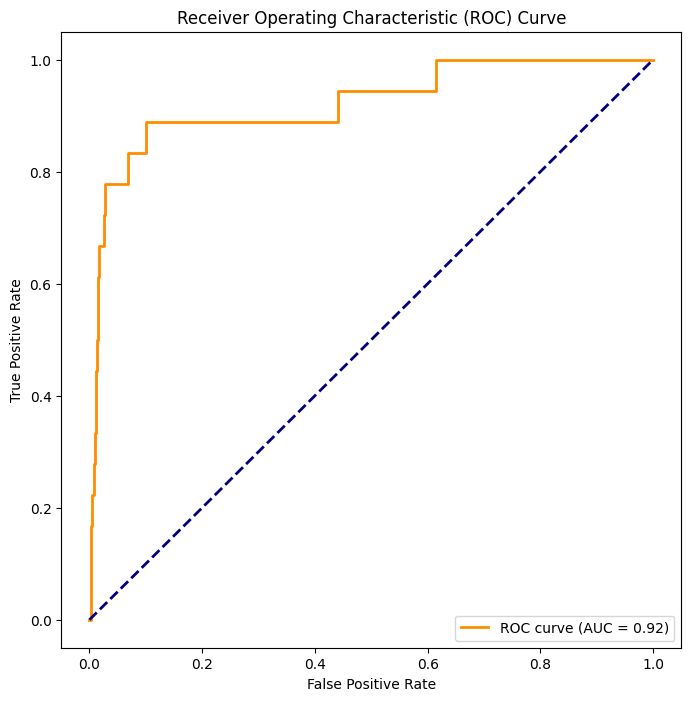

In [144]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The ROC-AUC shows that the model has good performance over a wide range of thresholds. The AUC score of 0.92 is considered to be very high, indicating that the model is able to distinguish between positive and negative cases very well.

In [145]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test)
average_precision = average_precision_score(y_test, y_pred_proba_test)

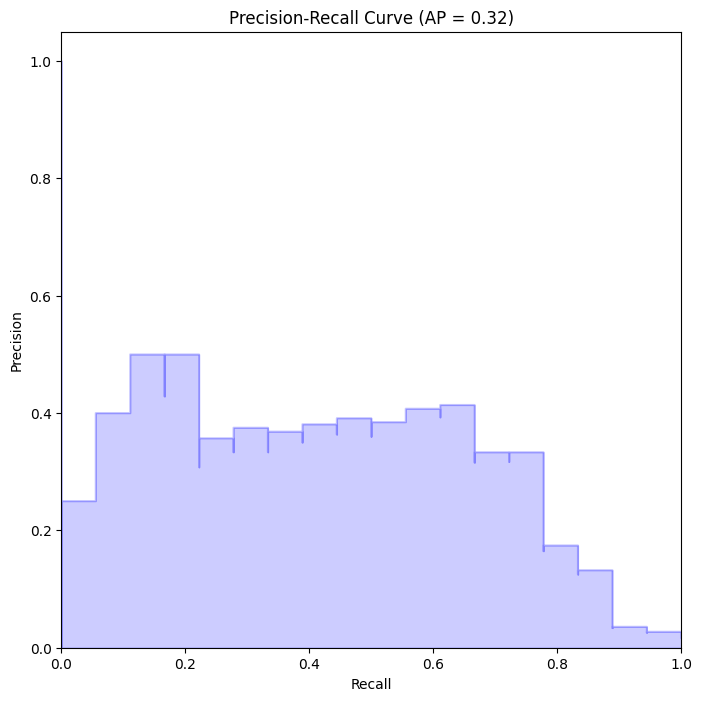

In [146]:
plt.figure(figsize=(8, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP = {:.2f})'.format(average_precision))
plt.show()

The precision-recall shows that the model has high precision at low recall values. This means that the model is good at identifying the positive cases, but it struggles to identify all of the positive cases. Which is in case of fradulent transactions should be treated positively. 

Though AP is 0.32 which means that this is not the best classifier.

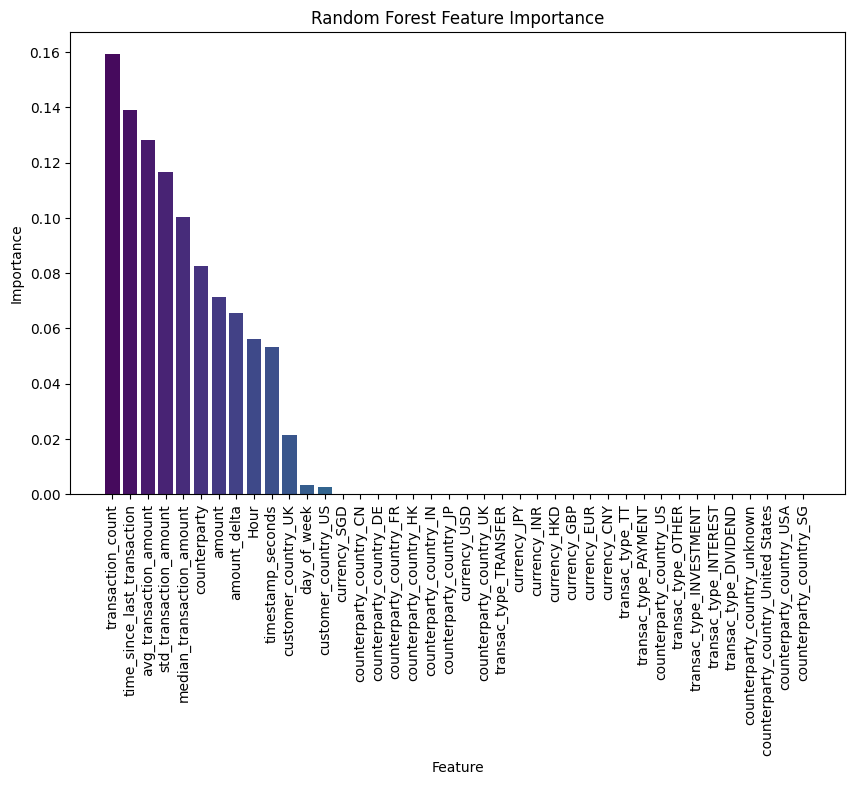

In [150]:
feature_importance = model.feature_importances_

feature_names = X.columns

sorted_idx = feature_importance.argsort()[::-1]

colors = sns.color_palette("viridis", len(feature_importance))

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align="center", color=colors)
plt.xticks(range(len(feature_importance)), feature_names[sorted_idx], rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()

According to this classidfier we can assume that multiple transactions at certain hour can have crucial impact to be classified as fradulent.

## <span style='color: violet;'>XGBoostr</span>

XGBoost (Extreme Gradient Boosting) is a powerful and efficient machine learning algorithm designed for supervised learning tasks, particularly regression and classification problems. It falls under the category of gradient boosting frameworks and is known for its high performance and scalability.

In [188]:
import xgboost as xgb
from sklearn.metrics import precision_score

In [189]:
def objective(trial):
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        
    bst = xgb.train(param, dtrain)
    
    preds = bst.predict(dvalid)
    y_pred = np.rint(preds)
    
    precision = precision_score(y_test, y_pred)
    
    return precision

In [215]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2024-01-09 21:43:19,071] A new study created in memory with name: no-name-6d9b9c15-fd6c-49bd-8970-7d8c1870b9d2
[I 2024-01-09 21:43:19,111] Trial 0 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 1.0445647903056869e-08, 'alpha': 0.0069429859964335, 'subsample': 0.5150972156902567, 'colsample_bytree': 0.3450787166268452}. Best is trial 0 with value: 0.0.
[I 2024-01-09 21:43:19,148] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 4.0165861614912314e-07, 'alpha': 0.11019573775732047, 'subsample': 0.44987419714995264, 'colsample_bytree': 0.5577660821145438}. Best is trial 0 with value: 0.0.
[I 2024-01-09 21:43:19,210] Trial 2 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 2.4651547594689258e-08, 'alpha': 0.04030399513317675, 'subsample': 0.37249904779978227, 'colsample_bytree': 0.26582991620861507, 'max_depth': 9, 'min_child_weight': 5, 'eta': 9.325497186983489e-08, 'gamma': 1.288711079403063e-07, 'grow

[I 2024-01-09 21:43:20,554] Trial 23 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 7.542033052289222e-08, 'alpha': 0.0450092779292047, 'subsample': 0.5197319139649044, 'colsample_bytree': 0.6957239554346193}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:20,607] Trial 24 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 6.088528138384604e-07, 'alpha': 0.9959046058353315, 'subsample': 0.44678820102651445, 'colsample_bytree': 0.35800962234040334}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:20,692] Trial 25 finished with value: 0.2727272727272727 and parameters: {'booster': 'gbtree', 'lambda': 4.355929985257649e-08, 'alpha': 0.002001117655948443, 'subsample': 0.33586244021029343, 'colsample_bytree': 0.43854683770715625, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.9668575230325743, 'gamma': 9.354226071700935e-07, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:20,776] Trial 26 finis

[I 2024-01-09 21:43:22,313] Trial 44 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 1.3271087580705267e-07, 'alpha': 8.602936081635619e-05, 'subsample': 0.27850917836900224, 'colsample_bytree': 0.31771016578176214, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.06139426170042315, 'gamma': 2.5635226664850606e-06, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:22,395] Trial 45 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 2.8733075493811196e-08, 'alpha': 0.0002506520979821458, 'subsample': 0.22540528452173914, 'colsample_bytree': 0.2565395624282291, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.30952583775084413, 'gamma': 2.1801674429940243e-05, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:22,482] Trial 46 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 6.553521320802125e-05, 'alpha': 8.139584056375417e-05, 'subsample': 0.314707596206356

[I 2024-01-09 21:43:24,194] Trial 64 finished with value: 0.8 and parameters: {'booster': 'gbtree', 'lambda': 5.328696516937436e-07, 'alpha': 2.9508471054647948e-06, 'subsample': 0.48068537720940113, 'colsample_bytree': 0.2833961889308944, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.4026516735571385, 'gamma': 0.00142053954269146, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:24,286] Trial 65 finished with value: 0.8333333333333334 and parameters: {'booster': 'gbtree', 'lambda': 4.242733232540448e-07, 'alpha': 2.430265797155854e-06, 'subsample': 0.4760575858254745, 'colsample_bytree': 0.2098591124514672, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4983455636048476, 'gamma': 0.0025133396890011012, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:24,382] Trial 66 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 2.523874166341346e-07, 'alpha': 5.64201463197725e-06, 'subsample': 0.3791487159

[I 2024-01-09 21:43:26,202] Trial 81 finished with value: 1.0 and parameters: {'booster': 'dart', 'lambda': 8.941007920242522e-07, 'alpha': 1.5385546121749157e-07, 'subsample': 0.40145488154123693, 'colsample_bytree': 0.27112763249261285, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.2119643119543091, 'gamma': 9.868324498674835e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.3188114551503993e-07, 'skip_drop': 0.05385996099340381}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:26,336] Trial 82 finished with value: 1.0 and parameters: {'booster': 'dart', 'lambda': 3.651651788775494e-07, 'alpha': 4.904196694070961e-07, 'subsample': 0.429429063463668, 'colsample_bytree': 0.24889768300651355, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.17521685393186212, 'gamma': 0.00028097092083827446, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.461374303755015e-07, 'skip_drop': 0.01874333041

[I 2024-01-09 21:43:28,158] Trial 98 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 4.846961345605938e-08, 'alpha': 7.404110422591118e-06, 'subsample': 0.28269379244891346, 'colsample_bytree': 0.34365701314259317}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:28,285] Trial 99 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 1.7564319928925796e-06, 'alpha': 1.2701108067023075e-07, 'subsample': 0.37390965499344186, 'colsample_bytree': 0.30065315517493024, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.15520803362088129, 'gamma': 1.0693272095390789e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.24567420294967e-07, 'skip_drop': 0.0005423960306130923}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:28,416] Trial 100 finished with value: 1.0 and parameters: {'booster': 'dart', 'lambda': 4.68642613063216e-07, 'alpha': 2.0526929460497383e-08, 'subsample': 0.3429522589171138,

[I 2024-01-09 21:43:30,168] Trial 115 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 8.864028064911295e-07, 'alpha': 1.0811019858512115e-07, 'subsample': 0.41387491163319634, 'colsample_bytree': 0.2746056389598042, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.12269309994646228, 'gamma': 8.736889215575331e-05, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:30,292] Trial 116 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 1.2062820810223772e-06, 'alpha': 2.5506555351331083e-05, 'subsample': 0.46686199469419626, 'colsample_bytree': 0.2359398921152454, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.053043406188859055, 'gamma': 2.68065022379963e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.5944253014355404e-08, 'skip_drop': 0.008732446825129206}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:30,380] Trial 117 finished with value: 1.0 and parame

[I 2024-01-09 21:43:32,150] Trial 132 finished with value: 1.0 and parameters: {'booster': 'dart', 'lambda': 1.274940506045855e-06, 'alpha': 5.558227119286182e-08, 'subsample': 0.34984711124241064, 'colsample_bytree': 0.3744018505810668, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.3516536591828845, 'gamma': 2.0192523477282205e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.951813532199005e-08, 'skip_drop': 0.10375586788504218}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:32,265] Trial 133 finished with value: 0.8571428571428571 and parameters: {'booster': 'dart', 'lambda': 6.863160512791999e-07, 'alpha': 1.548354669052667e-07, 'subsample': 0.37863568710246753, 'colsample_bytree': 0.29293072853262536, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7212664678148426, 'gamma': 8.89415475174065e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.2520414351495735e-07, 'skip_drop'

[I 2024-01-09 21:43:34,141] Trial 149 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 9.923253158865011e-07, 'alpha': 2.070454157424193e-08, 'subsample': 0.38719385975044, 'colsample_bytree': 0.2013356724683757, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.025368191018366276, 'gamma': 0.0009799441806673667, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.0891226593227953e-08, 'skip_drop': 0.00973933030955034}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:34,272] Trial 150 finished with value: 0.8333333333333334 and parameters: {'booster': 'dart', 'lambda': 3.516029887264934e-08, 'alpha': 1.9045690336118778e-07, 'subsample': 0.6817880486146674, 'colsample_bytree': 0.309082133050391, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5415697413049991, 'gamma': 0.00011444827722326692, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.545516273280671e-07, 'skip_drop': 

[I 2024-01-09 21:43:36,158] Trial 166 finished with value: 1.0 and parameters: {'booster': 'dart', 'lambda': 3.2127486963078992e-06, 'alpha': 4.9535158010049746e-05, 'subsample': 0.48344452599795246, 'colsample_bytree': 0.31572851363594484, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.13507968870968703, 'gamma': 8.876589679308137e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.210697594173512e-07, 'skip_drop': 0.013240267716335838}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:36,269] Trial 167 finished with value: 1.0 and parameters: {'booster': 'dart', 'lambda': 7.270261883522671e-07, 'alpha': 4.128140905124727e-07, 'subsample': 0.20006694813058098, 'colsample_bytree': 0.24100828344117048, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.6155632624390387, 'gamma': 1.3148779656132425e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.799578973366539e-08, 'skip_drop': 0.022010

[I 2024-01-09 21:43:38,168] Trial 183 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 1.4863849071100399e-08, 'alpha': 7.385406476720523e-08, 'subsample': 0.365528161913222, 'colsample_bytree': 0.27970142279092647, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.20920585810848047, 'gamma': 3.1290006778435635e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.7331145944102464e-06, 'skip_drop': 0.02597013486224104}. Best is trial 3 with value: 1.0.
[I 2024-01-09 21:43:38,292] Trial 184 finished with value: 1.0 and parameters: {'booster': 'dart', 'lambda': 1.2226228538065238e-06, 'alpha': 2.3360642834639095e-07, 'subsample': 0.28544178592524794, 'colsample_bytree': 0.24284087361880086, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.49048070761738954, 'gamma': 5.315439561160885e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 8.831180942465939e-07, 'skip_drop': 0.03635

In [216]:
best_params = study.best_params

print('The best parameters are: ', best_params)

The best parameters are:  {'booster': 'gbtree', 'lambda': 4.2581051708992175e-05, 'alpha': 0.004067132733536713, 'subsample': 0.7145056831811121, 'colsample_bytree': 0.36000197054269445, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2728067939818225, 'gamma': 1.6112458767261716e-07, 'grow_policy': 'depthwise'}


In [217]:
model = xgb.XGBClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(alpha=0.004067132733536713, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.36000197054269445, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.2728067939818225, eval_metric=None, feature_types=None,
              gamma=1.6112458767261716e-07, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=4.2581051708992175e-05, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

In [218]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

In [219]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

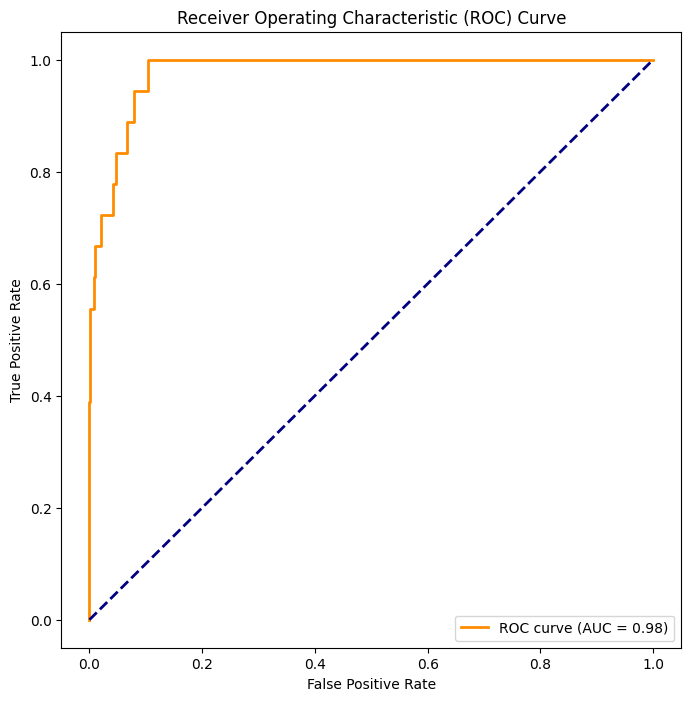

In [220]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

XGBClassifier is definitely doing better with classification of the fradulet trancasction which he AUC = 0.98.

In [221]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test)
average_precision = average_precision_score(y_test, y_pred_proba_test)

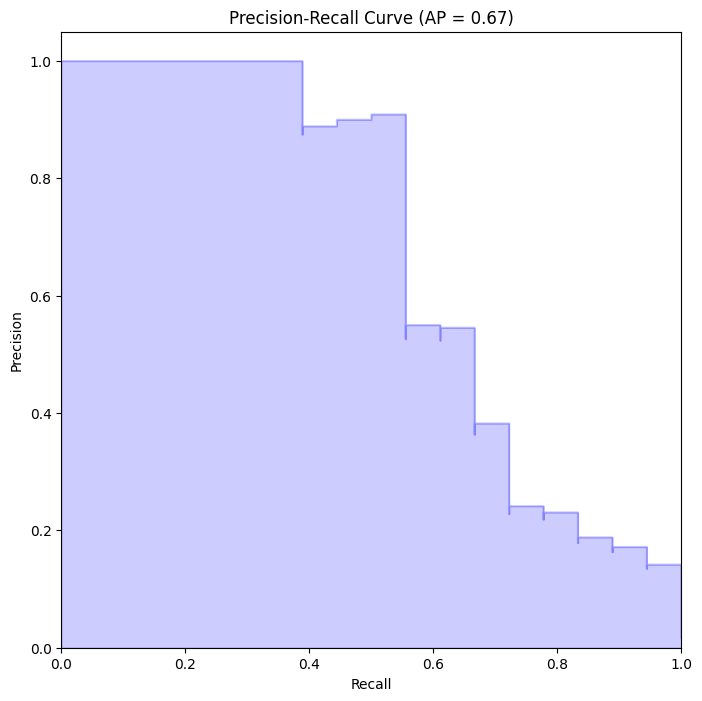

In [222]:
plt.figure(figsize=(8, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP = {:.2f})'.format(average_precision))
plt.show()

AP score is 0.67, which is considered to be above average. This means that the model is not performing well. The model is able to identify some positive cases, but it is also making a significant number of mistakes.

# Result

Let's save the best model using `pickle`.

In [223]:
import pickle

In [224]:
with open('xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

✨ Thank you very much for your time! ✨